# Multi Salmo microbetag networks analysis

## Dependencies

In [ ]:
import os
import pickle 
import itertools
import numpy as np 
import pandas as pd 
import warnings,logging
from pathlib import Path

# Plotting
from plotnine import stat_smooth
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import plotly.io as pio
import plotly.express as px
import webbrowser

# Utils
from utils import *


import cobra
# import math 


In [ ]:
warnings.filterwarnings("ignore", message=".*failed to parse.*")
logging.getLogger("cobra").setLevel(logging.ERROR)

In [ ]:
root_dir   = Path(".").parent.parent.resolve()
mgg_prec   = root_dir / "mgg_prec"
genres_dir = mgg_prec / "reconstructions/GENREs"

rxns_v    = [] ; mets_v        = []
ex_rxns_v = [] ; medium_rnxs_v = []

for index, model_name in enumerate(os.listdir(genres_dir)):

    print(index)

    model_path = genres_dir / model_name

    model = cobra.io.read_sbml_model(model_path)

    rxns_v.append(len(model.reactions))
    mets_v.append(len(model.metabolites))
    ex_rxns_v.append(len(model.exchanges))
    medium_rnxs_v.append(len(model.medium))

In [11]:
# So you do not run again..
rxns_v        = [1575, 1597, 1670, 1414, 1780, 1330, 1260, 1372, 1283, 1264, 1363, 1535, 1322, 1609, 1412, 1595, 1648, 1408, 1404, 1545, 1527, 905, 1509, 1735, 1443, 1638, 1425, 1121, 1549, 1557, 1444, 1149, 1595, 1628, 1017, 1195, 1435, 1512, 865, 1401, 1059, 1096, 1466, 1701, 1627, 1626, 1289, 1402, 1262, 1689, 1521, 1383, 960, 1442, 1472, 1335, 1440, 1455, 2581, 1553, 1529, 1325, 1728, 981, 1470, 1308, 1274, 1702, 1184, 1631, 1458, 1378, 1609, 884, 1526, 1538, 1123, 1471, 705, 1421, 1528, 1214, 2627, 1507, 1691, 1478, 743, 1507, 1453, 1322, 1399, 1374, 1384, 1442, 1547, 1263, 1619, 1381, 1214, 1490, 1639, 1391, 1624, 1427, 2835, 1528, 1680, 1660, 1233, 1387, 890, 1090, 1375, 1312, 1155, 1297, 1484, 1356, 1568, 1394, 1343, 1376, 1116, 1513, 1645, 1429, 1593, 1444, 798, 1342, 1463, 1649, 1644, 1586, 893, 1550, 1254, 1454, 1433, 1190, 1576, 1479, 1367, 1575, 1581, 1143, 1346, 1569, 1513, 1618, 824, 1526, 1571, 843, 1386, 1577, 1365, 1445, 1655, 1452, 1517, 1143, 1413, 1345, 1532, 1591, 1375, 1564, 1408, 1386, 1400, 901, 1301, 973, 2407, 1341, 2150, 1320, 1393, 1535, 1438, 1299, 1523, 1295, 1508, 1671, 1534, 1580, 1269, 1451, 1416, 1452, 1362, 1517, 1076, 1623, 1375, 1344, 1582, 1553, 1294, 1427, 1485, 1572, 1039, 1379, 1310, 1452, 1512, 1503, 1568, 1447, 1448, 1542, 1323, 1315, 779, 1548, 1441, 1271, 1332, 1409, 1404]
mets_v        = [1084, 1114, 1150, 980, 1191, 983, 935, 942, 944, 934, 965, 1042, 934, 1127, 1026, 1104, 1131, 998, 961, 1079, 1042, 699, 1076, 1159, 1023, 1096, 987, 836, 1092, 1075, 1004, 850, 1133, 1147, 742, 861, 977, 1034, 679, 990, 764, 818, 1017, 1160, 1095, 1125, 909, 965, 901, 1148, 1073, 978, 748, 1029, 1030, 956, 1006, 1013, 1642, 1076, 1071, 936, 1188, 775, 1024, 944, 915, 1159, 867, 1118, 1034, 960, 1104, 693, 1058, 1050, 825, 1025, 584, 987, 1067, 876, 1664, 1051, 1154, 1023, 593, 1041, 1012, 933, 959, 1011, 1017, 990, 1095, 893, 1093, 966, 890, 1032, 1138, 1001, 1099, 1014, 1755, 1073, 1100, 1116, 885, 952, 705, 819, 956, 944, 852, 927, 1035, 971, 1063, 965, 970, 973, 838, 1043, 1101, 1013, 1073, 1009, 633, 970, 1013, 1108, 1132, 1126, 703, 1059, 908, 999, 1007, 885, 1110, 1035, 991, 1089, 1113, 840, 959, 1060, 1034, 1104, 666, 1086, 1082, 664, 982, 1083, 962, 999, 1121, 996, 1019, 865, 1017, 965, 1101, 1092, 980, 1049, 1002, 954, 1011, 700, 916, 763, 1546, 952, 1370, 922, 986, 1050, 998, 961, 1075, 927, 1024, 1165, 1044, 1071, 897, 992, 984, 1024, 977, 1042, 811, 1117, 978, 978, 1110, 1045, 934, 1002, 1040, 1077, 773, 963, 955, 1036, 1036, 1037, 1058, 1024, 998, 1062, 922, 957, 629, 1051, 985, 928, 946, 996, 983]
ex_rxns_v     = [210, 208, 208, 168, 213, 171, 165, 206, 154, 163, 138, 186, 148, 206, 171, 203, 194, 151, 158, 190, 168, 127, 175, 220, 156, 203, 185, 155, 195, 199, 177, 154, 165, 188, 156, 178, 161, 193, 122, 178, 143, 154, 189, 202, 184, 206, 165, 205, 158, 216, 165, 194, 128, 168, 172, 179, 190, 182, 352, 193, 187, 145, 212, 130, 174, 162, 175, 198, 143, 192, 160, 182, 206, 114, 181, 183, 153, 191, 111, 176, 185, 168, 350, 196, 205, 173, 109, 177, 193, 173, 179, 176, 186, 164, 159, 177, 200, 149, 166, 194, 192, 160, 196, 176, 379, 207, 206, 211, 156, 156, 126, 155, 181, 170, 127, 166, 206, 170, 196, 163, 171, 152, 146, 185, 199, 169, 184, 174, 126, 170, 179, 213, 195, 194, 104, 195, 173, 192, 178, 138, 181, 193, 160, 208, 200, 148, 193, 188, 172, 173, 110, 174, 210, 110, 146, 183, 172, 171, 202, 177, 170, 137, 180, 160, 172, 199, 161, 213, 176, 178, 183, 127, 188, 125, 354, 174, 261, 151, 190, 193, 181, 157, 203, 165, 195, 196, 212, 182, 151, 192, 159, 164, 186, 165, 136, 210, 139, 165, 193, 180, 178, 182, 192, 198, 129, 193, 171, 184, 184, 174, 193, 189, 178, 188, 179, 173, 112, 181, 165, 170, 160, 184, 185]
medium_rnxs_v = [210, 208, 208, 168, 213, 171, 165, 206, 154, 163, 138, 186, 148, 206, 171, 203, 194, 151, 158, 190, 168, 127, 175, 220, 156, 203, 185, 155, 195, 199, 177, 154, 165, 188, 156, 178, 161, 193, 122, 178, 143, 154, 189, 202, 184, 206, 165, 205, 158, 216, 165, 194, 128, 168, 172, 179, 190, 182, 352, 193, 187, 145, 212, 130, 174, 162, 175, 198, 143, 192, 160, 182, 206, 114, 181, 183, 153, 191, 111, 176, 185, 168, 350, 196, 205, 173, 109, 177, 193, 173, 179, 176, 186, 164, 159, 177, 200, 149, 166, 194, 192, 160, 196, 176, 379, 207, 206, 211, 156, 156, 126, 155, 181, 170, 127, 166, 206, 170, 196, 163, 171, 152, 146, 185, 199, 169, 184, 174, 126, 170, 179, 213, 195, 194, 104, 195, 173, 192, 178, 138, 181, 193, 160, 208, 200, 148, 193, 188, 172, 173, 110, 174, 210, 110, 146, 183, 172, 171, 202, 177, 170, 137, 180, 160, 172, 199, 161, 213, 176, 178, 183, 127, 188, 125, 354, 174, 261, 151, 190, 193, 181, 157, 203, 165, 195, 196, 212, 182, 151, 192, 159, 164, 186, 165, 136, 210, 139, 165, 193, 180, 178, 182, 192, 198, 129, 193, 171, 184, 184, 174, 193, 189, 178, 188, 179, 173, 112, 181, 165, 170, 160, 184, 185]

In [23]:
print(
    rxns_v, '\n',
    mets_v, '\n',
    ex_rxns_v, '\n',
    medium_rnxs_v
)

[1575, 1597, 1670, 1414, 1780, 1330, 1260, 1372, 1283, 1264, 1363, 1535, 1322, 1609, 1412, 1595, 1648, 1408, 1404, 1545, 1527, 905, 1509, 1735, 1443, 1638, 1425, 1121, 1549, 1557, 1444, 1149, 1595, 1628, 1017, 1195, 1435, 1512, 865, 1401, 1059, 1096, 1466, 1701, 1627, 1626, 1289, 1402, 1262, 1689, 1521, 1383, 960, 1442, 1472, 1335, 1440, 1455, 2581, 1553, 1529, 1325, 1728, 981, 1470, 1308, 1274, 1702, 1184, 1631, 1458, 1378, 1609, 884, 1526, 1538, 1123, 1471, 705, 1421, 1528, 1214, 2627, 1507, 1691, 1478, 743, 1507, 1453, 1322, 1399, 1374, 1384, 1442, 1547, 1263, 1619, 1381, 1214, 1490, 1639, 1391, 1624, 1427, 2835, 1528, 1680, 1660, 1233, 1387, 890, 1090, 1375, 1312, 1155, 1297, 1484, 1356, 1568, 1394, 1343, 1376, 1116, 1513, 1645, 1429, 1593, 1444, 798, 1342, 1463, 1649, 1644, 1586, 893, 1550, 1254, 1454, 1433, 1190, 1576, 1479, 1367, 1575, 1581, 1143, 1346, 1569, 1513, 1618, 824, 1526, 1571, 843, 1386, 1577, 1365, 1445, 1655, 1452, 1517, 1143, 1413, 1345, 1532, 1591, 1375, 1564, 140

In [33]:
len([x for x in rxns_v if x < 1000]) / len(rxns_v) * 100
# len([x for x in rxns_v if x < 1000])

6.726457399103139

In [39]:
len([x for x in mets_v if x < 800]) / len(mets_v) * 100
# len([x for x in mets_v if x < 800])

8.071748878923767

In [5]:
genome_quality  = pd.read_csv("../data/genomeInfo.csv")

In [6]:
genome_size = genome_quality["length"].values.tolist()

In [7]:
genome_quality[genome_quality["length"] < 1e6].shape
genome_quality[genome_quality["length"] > 1e7].shape

(1, 5)

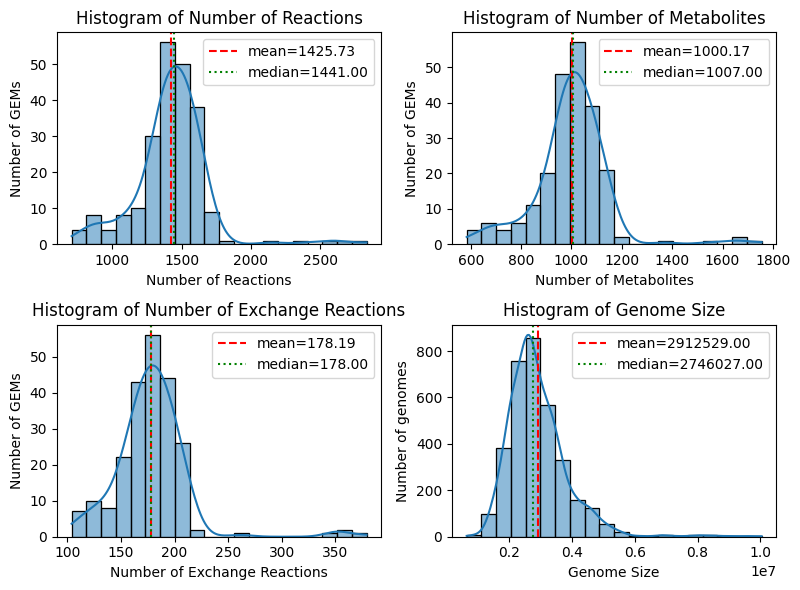

In [12]:

x_titles = ["Number of Reactions", "Number of Metabolites", "Number of Exchange Reactions", "Genome Size" ]  # "Number of Medium Reactions"
y_titles = ["Number of GEMs", "Number of GEMs", "Number of GEMs", "Number of genomes"]

fig,axes=plt.subplots(2,2,figsize=(8,6))
axes=axes.flatten()

for index,vals in enumerate([rxns_v,mets_v,ex_rxns_v,genome_size]):

    sns.histplot(vals, bins=20, kde=True, ax=axes[index])

    mean   = np.mean(vals)
    median = np.median(vals)

    axes[index].axvline(mean,color='red',linestyle='--',label=f"mean={mean:.2f}")
    axes[index].axvline(median,color='green',linestyle=':',label=f"median={median:.2f}")
    axes[index].legend()

    axes[index].set_title(f"Histogram of {x_titles[index]}")
    axes[index].set_xlabel(x_titles[index])
    axes[index].set_ylabel(y_titles[index])


plt.tight_layout()
plt.show()



In [ ]:
with open("mgg_prec/seeds_complementarity/seed_complements.pckl", "rb") as f:
    seeds_df = pickle.load(f)

In [15]:
print(
    "theoretical total:", seeds_df.shape[1] ** 2 - seeds_df.shape[1],
    "actual total:", seeds_df.applymap(lambda x: isinstance(x, list) and len(x) > 0).sum().sum()
)

theoretical total: 49506 actual total: 47976


/tmp/ipykernel_531704/1351659025.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [17]:
counter = 0
number_of_complements = []
times_a_compound_is_a_complement = {}
for i in range(seeds_df.shape[0]):
    for j in range(seeds_df.shape[1]):
        if len(seeds_df.iat[i, j]) > 0:
            number_of_complements.append(len(seeds_df.iat[i, j]))
            
            for compound in seeds_df.iat[i, j]:
                if compound not in times_a_compound_is_a_complement:
                    times_a_compound_is_a_complement[compound] = 0
                times_a_compound_is_a_complement[compound] += 1

<Axes: ylabel='Count'>

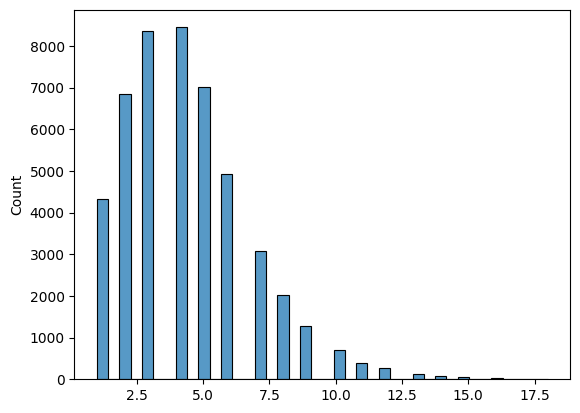

In [31]:
sns.histplot(number_of_complements, bins=40)

In [ ]:
print(
    "total unique compounds that are complements:",
    len(times_a_compound_is_a_complement),
    "number of ",
    len(set(sorted(list(times_a_compound_is_a_complement.values()))))
)


total unique compounds that are complements: 109 number of  98


<Axes: ylabel='Count'>

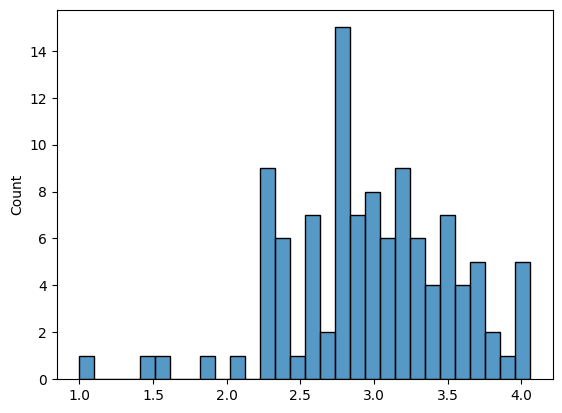

In [ ]:
log10_values = np.log10(list(times_a_compound_is_a_complement.values()))
# sns.histplot(list(times_a_compound_is_a_complement.values()), bins=100)
sns.histplot(list(log10_values), bins=30)

In [ ]:
# sorted(list(times_a_compound_is_a_complement.values()))[-1]
# math.log10(10710)

11520

## Building `microbetag`-annotated networks

### Data pre-process

Original files

- abundance data file: `salm_multi_filtered_30.tsv` (date: 27/05/2025 - email correspondence)
- taxonomy file: `salm_multio_abd_table_gc.tsv` (since the filtered_30 abundance data file has no classification column, we will use a previous version of the file to make sure we map the MAG ID to the correct taxonomy)
- metadata file: `sample_metadata_corrected.csv` (date: 20/6/25 - discord message ; yet metabolites not included)
- metabolites data: `original_mets_data_20250113.xlsx` (cannot track how I got this)

In the following chunk we bring the samples of the two files (columns) in the same order -- necessary for FlashWeave to build networks using metadata. 

In [24]:
abundance_file   = "salm_multi_filtered_30.tsv"
taxonomy_file    = "salm_multio_abd_table_gc.tsv"
metadata_file    = "sample_metadata_corrected.csv"
metabolites_file = "original_mets_data_20250113.xlsx"
template_config  = "config_v104.yml"

Load libraries and set root paths.

In [34]:
root            = Path(os.getcwd())
input_data      = root / "data"
microbetag_data = root / "microbetag_input/"

Load abundance data

In [35]:
abd = pd.read_csv(input_data / abundance_file, sep="\t", index_col=0)
abd.head(2)

,D300530,D300531,D300470,D300477,D300433,D300479,D300436,D300445,D300521,D300514,...,D300524,D300469,D300520,D300505,D300493,D300499,D300503,D300464,D300515,D300497
genome,,,,,,,,,,,,,,,,,,,,,
D300418:bin_000001,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D300418:bin_000013,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Load metadata file, mapping samples to their corresponding treatment and day.
In the following table we provide a short description of the treatments. 

|  Factor        |	TG1 | TG2 |	TG3 | TG4 | TG5 |
|:--------------:|:----:|:---:|:---:|:---:|:---:|
|salmonella	     | Yes	| Yes | Yes | Yes | No  |
|synbiotic_water | Yes	| Yes |	No  | No  |	No  |
|synbiotic_feed	 | Yes	| No  |	Yes | No  | No  |



In [36]:
metadata = pd.read_csv(input_data / metadata_file)
metadata.head(2)

,sample,batch,animal,tissue,treatment,day
0,D300530,S3B009,G000,Digesta,TG0,NaN
1,D300531,S3B009,G000,Digesta,TG0,NaN


In the metabolites file, you may see that a great number of metabolites were measured in the study, however we selected the most relevant that could affect the samples' communities, and we kept their values in the 'of-interest' sheet.

In [37]:
mets = pd.read_excel(input_data / metabolites_file, sheet_name="of-interest")

# For some reason there is an extra "M" in the end of the sample name 
mets.columns = [mets.columns[0]] + [col[:-1] for col in mets.columns[1:]]
mets.head(2)

,metabolite,G124,G030,G066,G044,G020,G113,G031,G050,G118,...,G007,G029,G032,G111,G017,G048,G026,G027,G104,G094
0,L-Tyrosine,1.154862e+06,1.070405e+06,7.233821e+05,1.439299e+06,632785.722057,1.157299e+06,6.014387e+05,1.961503e+06,1.125862e+06,...,6.721533e+05,462266.471921,471502.748026,1.546473e+06,328951.773787,656204.241988,2.938963e+06,4.103840e+06,1.906260e+06,1.910604e+06
1,L-Phenylalanine,1.233174e+06,1.647481e+06,1.049884e+06,2.071581e+06,681458.305129,2.325329e+06,1.862486e+06,2.386789e+06,1.744189e+06,...,2.686876e+06,727284.939809,955339.135261,2.574471e+06,525748.264667,753097.476399,2.199197e+07,2.619296e+07,1.816819e+06,2.377164e+06


We will now merge the metabolites' data with the rest of the metadata of each sample, so we use their combination to infer microbial co-occurrence networks with FlashWeave. 
To this end, we will use the `animal` column of the metadata, that has been used as the sample name for the metabolites' measurements. 

In [38]:
# Ensure 'metabolite' is set as index so rows are labeled by metabolite name
mets_indexed = mets.set_index('metabolite')

# Loop over each metabolite (each row in mets) and map values to metadata
for metabolite in mets_indexed.index:
    metadata[metabolite] = metadata['animal'].map(mets_indexed.loc[metabolite].to_dict())

print(metadata.shape)
metadata.head(2)


(114, 29)


,sample,batch,animal,tissue,treatment,day,L-Tyrosine,L-Phenylalanine,L-Tryptophan,L-Aspartic Acid,...,Thiamine,Adenine,Guanosine,L-Valine,L-Alanine,L-Asparagine,L-Isoleucine,L-Serine,Lactic acid,Sulfoacetic acid
0,D300530,S3B009,G000,Digesta,TG0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D300531,S3B009,G000,Digesta,TG0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
metadata[metadata["animal"] == "G003"]

,sample,batch,animal,tissue,treatment,day,L-Tyrosine,L-Phenylalanine,L-Tryptophan,L-Aspartic Acid,...,Thiamine,Adenine,Guanosine,L-Valine,L-Alanine,L-Asparagine,L-Isoleucine,L-Serine,Lactic acid,Sulfoacetic acid
93,D300477,S3B009,G003,Digesta,TG5,14.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And to bring it a `microbetag`-friendly format, we will transpose the table.

In [40]:
metadata = metadata.T
metadata.columns = metadata.iloc[0]
metadata = metadata.drop(metadata.index[0])

# Make day an integer -- not a float
metadata.loc["day"] = metadata.loc["day"].astype('Int64')

metadata.head(2)

sample,D300530,D300531,D300529,D300480,D300517,D300428,D300509,D300516,D300510,D300483,...,D300524,D300469,D300520,D300505,D300493,D300499,D300503,D300464,D300515,D300497
batch,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,...,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009
animal,G000,G000,G085,G086,G087,G088,G089,G090,G091,G092,...,G115,G116,G118,G119,G120,G121,G122,G123,G124,G125


You may notice that `metadata` now, have 114 columns, thus 114 samples, as many as the abundance table, but the original `metabolites` dataframe had only 112; this is because no measurements were taken for the two blank samples.
Those two samples (`D300530` and `D300531`) have `NaN` values across all their metabolites. 

We can now check that our abundance and metadata dataframes have the same elements across their columns.

In [41]:
set(abd.columns) == set(metadata.columns)

True

However, even if the columns are the same, their order is **different**! 

In [42]:
set(abd.columns) == set(metadata.columns) and list(abd.columns) != list(metadata.columns)

True

>  ⚠️ **ATTENTION!**
> 
> It is essential we have the same order on the two dataframes for FlashWeave. 

In [43]:
abd_reordered = abd[metadata.columns]

Yet, FlashWeave cannot handle with null values, meaning we need to remove such cases from both abundance and metadata dataframes. 

In [44]:
metadata_cl, dropped_samples = remove_cols_with_null(metadata)
dropped_samples

Index(['D300477', 'D300530', 'D300531'], dtype='object', name='sample')

In [45]:
abd_cl, dropped_samples_abd = remove_cols_with_null(abd_reordered)
dropped_samples_abd

Index([], dtype='object')

We observe that only in the case of the metadata dataframe we had some null values, in three samples that correspond to the two blank ones ('D300530', 'D300531') and a TG5/day14 one (animal G003).

Yet, we need to remove those three samples from the `abd` dataframe too. 

In [46]:
abd_reordered = abd_reordered.drop(columns=dropped_samples)

From the original abundance file we have been using, we miss the **taxonomic assignment** of the genomes.

In [47]:
tax = pd.read_csv(input_data / taxonomy_file, sep = "\t")
tax = tax[["genome", "classification"]]
tax.head()

,genome,classification
0,D300418:bin_000001,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
1,D300418:bin_000013,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
2,D300428:bin_000008,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Ch...
3,D300430:bin_000010,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
4,D300432:bin_000001,d__Bacteria;p__Bacillota_A;c__Clostridia;o__La...


>  ⚠️ **ATTENTION!**
>
> To make our lives easier we will rename our basic dataframes to `abd` and `metadata`, but **remember** that they are not the original ones, but the ones after all the pre-processing steps.

In [48]:
abd      = abd_reordered.merge(tax, on='genome', how='left')
metadata = metadata_cl

🔔 We can now run a second test to check whether the order of the column names is the same in the two dataframes, excluding the non-numeric columns of the `abd` (`genome` and `classification`). 

In [49]:
abd.select_dtypes(include=['number']).columns.to_list() == metadata.columns.to_list()

True

So, we can now export the two basic files to be used for the `microbetag` analysis in its required format.

In [22]:
abd.to_csv(microbetag_data / "abundance.tsv", sep="\t", index=False)
metadata.to_csv(microbetag_data / "metadata.tsv", sep="\t")  # header=False

### Data sanity check

⚪ We can now check a couple of things on our data to check whether they agree with what's expected. 

In [50]:
probiotics = {
    "Bifidobacterium animalis": "GEXTRA:bin_000001",
    "Enterococcus faecium"    : "GEXTRA:bin_000002",
    "Lactobacillus salivarius": "GPB:bin_000025",
    "Lactobacillus reuteri"   : "GEXTRA:bin_000004",  # TG2:bin_000003
    "Pediococcus acidilactici": "GEXTRA:bin_000006"
}
salmonella_bin = "GPB:bin_000051"

We split data in two types, per _day_, having 5 cases: 7, 14, 21, 28 and 35,

and per _treatment_, as explained in the table above. 

In [51]:
types = ["day", "treatment"]

Get mean abundance of the probiotics under study across the different cases exampined.

In [52]:
species_case_avg = {}

for type in types:
    species_case_avg[type] = {}
    for case in metadata.loc[type, :].unique():
        species_case_avg[type][case] = {}
        for probiotic, genome in probiotics.items():
            av_std = mean_genome_abd(abd, metadata, genome, type, case)
            species_case_avg[type][case][probiotic] = av_std.item()

So, per day, probiotics range like:

In [24]:
pd.DataFrame.from_dict(species_case_avg["day"])

,35,28,21,14,7
Bifidobacterium animalis,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.5108 ± 1.6582
Enterococcus faecium,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Lactobacillus salivarius,3.6914 ± 5.9958,2.953 ± 4.7583,3.5103 ± 4.7295,3.3329 ± 6.7903,8.5769 ± 10.8855
Lactobacillus reuteri,0.0 ± 0.0,0.0467 ± 0.2333,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Pediococcus acidilactici,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0


and per treatment:

In [25]:
pd.DataFrame.from_dict(species_case_avg["treatment"])

,TG1,TG2,TG3,TG4,TG5
Bifidobacterium animalis,0.3113 ± 1.4267,0.0711 ± 0.3408,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Enterococcus faecium,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Lactobacillus salivarius,12.2813 ± 7.9927,8.6891 ± 5.5627,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Lactobacillus reuteri,0.0555 ± 0.2545,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Pediococcus acidilactici,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0


Let's see now what about _Salmonella_.

In [58]:
from itertools import product

# Get all combinations of unique values from 'day' and 'treatment'
cases = {key: metadata.loc[key].unique() for key in ['day', 'treatment']}
combinations = list(product(cases['day'], cases['treatment']))

# Prepare results dictionary
results = {}

for day, treatment in combinations:
    # Find matching sample columns
    mask = (metadata.loc["day"] == day) & (metadata.loc["treatment"] == treatment)
    samples = metadata.columns[mask]

    # Subset abundance table
    selected_cols = ["genome"] + samples.tolist()
    sub_df = abd[selected_cols]

    # Get abundance values for the Salmonella genome
    s_abd = sub_df[sub_df["genome"] == salmonella_bin].select_dtypes(include="number")

    # Compute mean ± std and store in nested dictionary
    mean = s_abd.mean(axis=1).round(4)
    std = s_abd.std(axis=1).round(4)
    formatted = f"{mean.item()} ± {std.item()}"

    # Store result
    results.setdefault(day, {})[treatment] = formatted

# Make a df 
summary_df = pd.DataFrame.from_dict(results, orient="index").sort_index().reindex(sorted(cases['treatment']), axis=1)
summary_df

,TG1,TG2,TG3,TG4,TG5
7,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
14,2.0765 ± 0.6141,1.8698 ± 2.2075,1.482 ± 0.8813,2.8747 ± 3.3396,0.0 ± 0.0
21,0.2293 ± 0.5127,0.8378 ± 0.798,0.5409 ± 0.5134,0.0 ± 0.0,0.0 ± 0.0
28,1.027 ± 1.6261,0.0 ± 0.0,0.4396 ± 0.4096,0.4326 ± 0.6528,0.0 ± 0.0
35,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0


Let's now have a look on how many taxa are present in each case and how they distribute across the type's samples. 

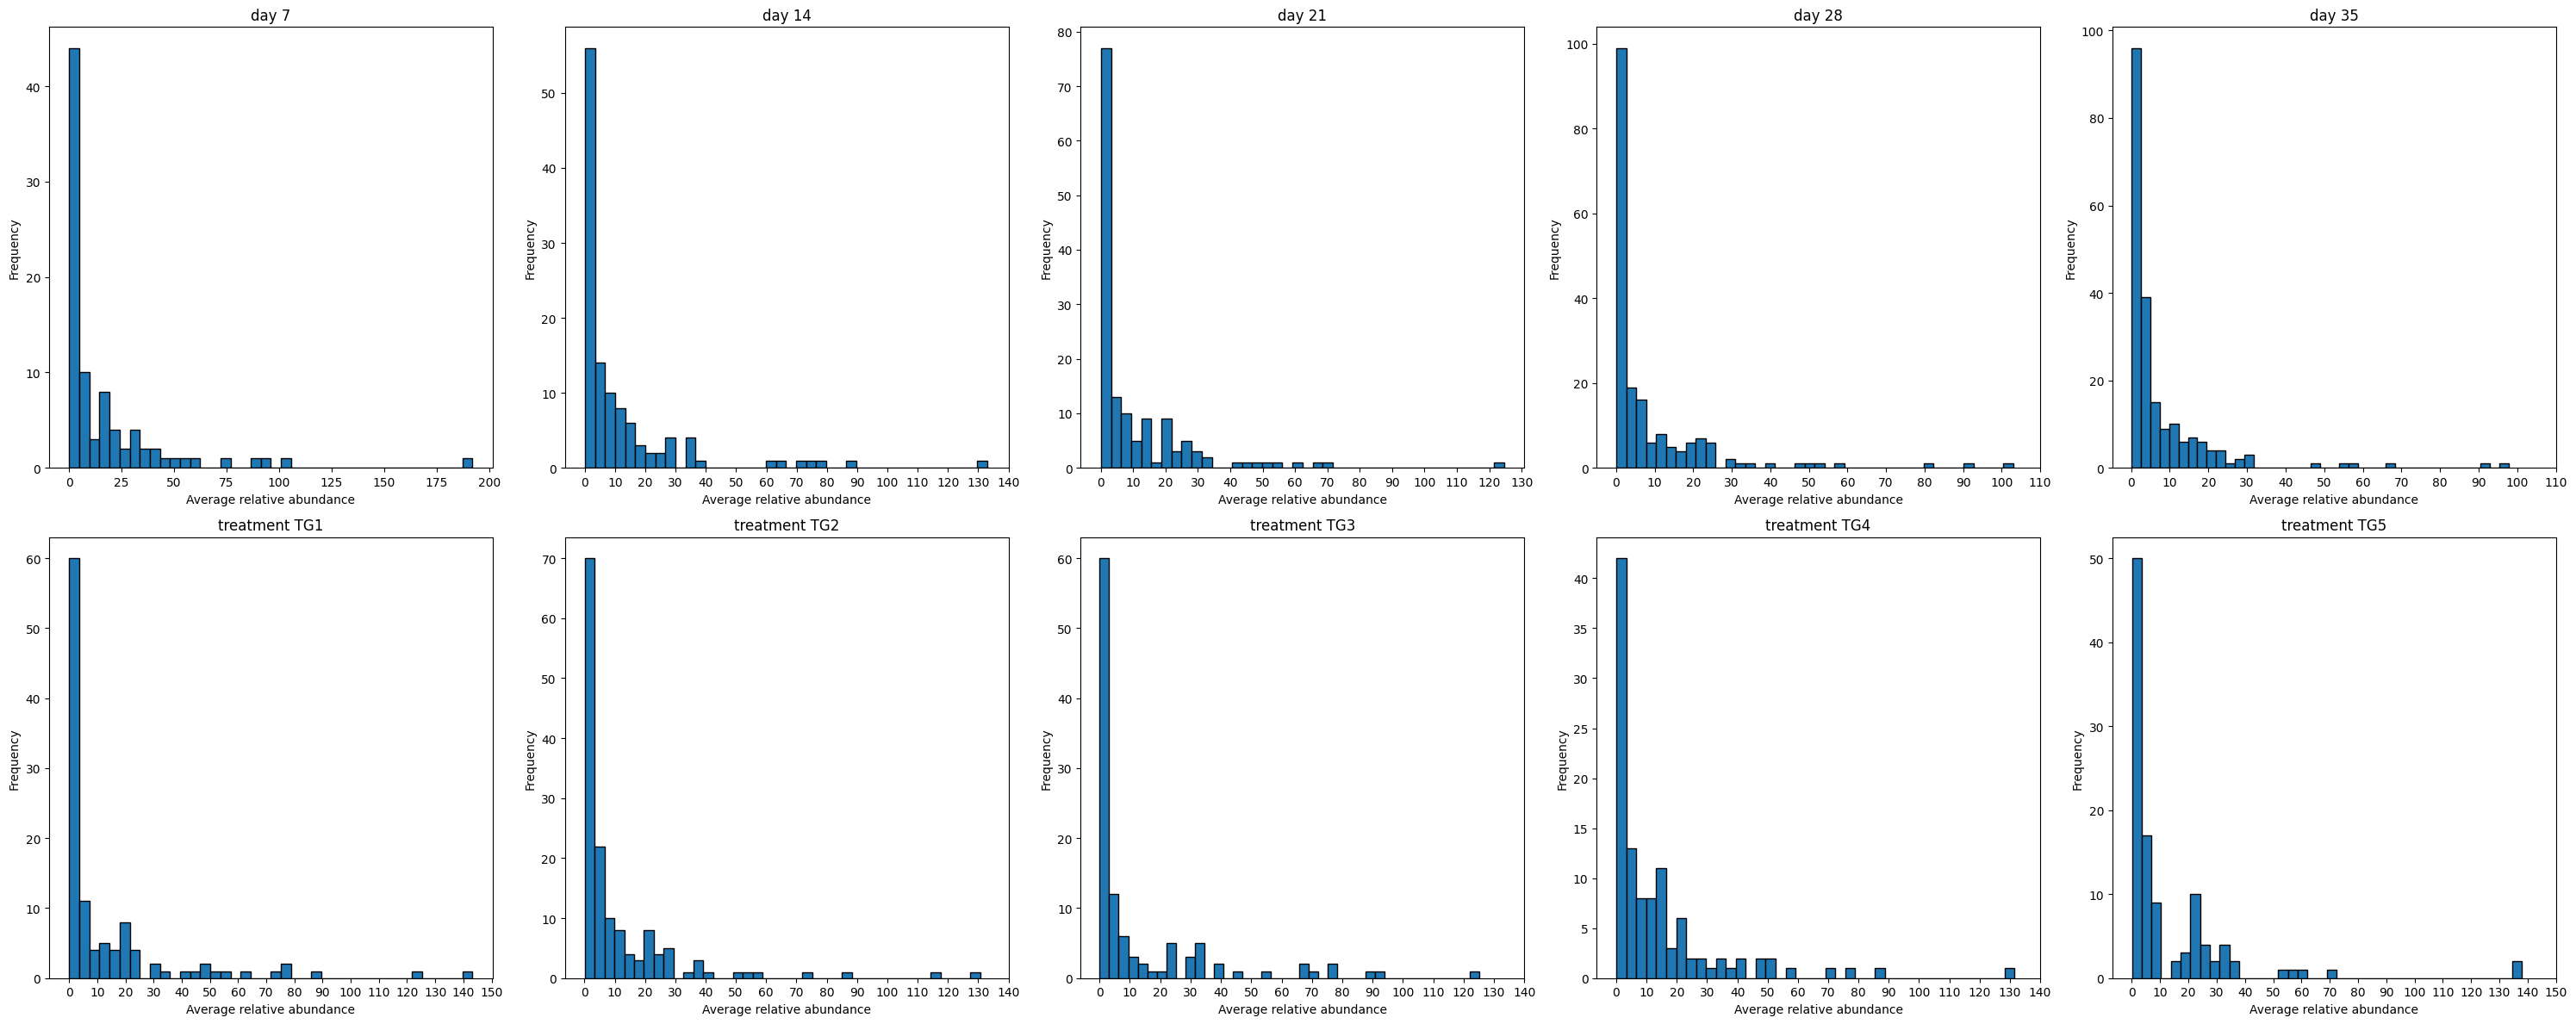

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(30, 12))  # 5 rows × 2 columns
axes = axes.flatten()   # Flatten to 1D array for easy indexing

plot_idx = 0  # Counter for subplot index

type_case_n_taxa = {}

for type in types:

    type_case_n_taxa[type] = {}

    for case in sorted(metadata.loc[type].unique()):  # Assuming metadata is a DataFrame with `type` as index

        samples  = metadata.columns[metadata.loc[type] == case]
        sub_df   = abd[["genome"] + samples.tolist() + ["classification"]]
        abd_data = sub_df.select_dtypes(include=['number'])

        # Identify numeric columns
        numeric_cols = abd_data.columns

        # Keep only rows where there is at least one non-zero value
        df_cleaned            = sub_df[(abd_data[numeric_cols] != 0).any(axis=1)].copy()
        df_cleaned["average"] = df_cleaned[numeric_cols].mean(axis=1)

        type_case_n_taxa[type][case] = df_cleaned.select_dtypes("number").shape[0]
        
        if plot_idx >= len(axes):
            print(f"Skipping plot {type}-{case}: too many plots for the 5×2 grid.")
            continue

        # Place subplot on the grid
        ax = axes[plot_idx]

        # Main plot
        ax.hist(df_cleaned["average"], bins=40, edgecolor='black')

        # Define tick step
        tick_step = 10
        xmin, xmax = ax.get_xlim()
        if int(xmax) < 200:
            ax.set_xticks(np.arange(0, int(xmax) + tick_step, tick_step))

        ax.set_xlabel("Average relative abundance")
        ax.set_ylabel("Frequency")
        ax.set_title(f"{type} {case}")

        plot_idx += 1

# Hide unused subplots
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])  # or: axes[j].axis('off')


fig.savefig("figs/mean_abundance_per_case.svg", format="svg", dpi=300)

plt.tight_layout()
plt.show()


In [56]:
from IPython.display import display, Markdown

df_day   = pd.DataFrame.from_dict(type_case_n_taxa['day'], orient='index', columns=['Sample count'])
df_treat = pd.DataFrame.from_dict(type_case_n_taxa['treatment'], orient='index', columns=['Sample count'])

day_md   = df_day.reset_index().rename(columns={'index': 'Day'}).to_markdown(index=False)
treat_md = df_treat.reset_index().rename(columns={'index': 'Treatment'}).to_markdown(index=False)

display(Markdown(f"### Number of taxa present in the *per day* case\n\n{day_md}"))
display(Markdown(f"### Number of taxa present in the *per treatment* case\n\n{treat_md}"))

### Number of taxa present in the *per day* case

|   Day |   Sample count |
|------:|---------------:|
|     7 |             88 |
|    14 |            117 |
|    21 |            146 |
|    28 |            188 |
|    35 |            208 |

### Number of taxa present in the *per treatment* case

| Treatment   |   Sample count |
|:------------|---------------:|
| TG1         |            112 |
| TG2         |            146 |
| TG3         |            110 |
| TG4         |            110 |
| TG5         |            109 |

You may check for example whether you do have evnn using what we argue we use the following to check the treatment and the day.

### Build input files for `microbetag`

Since we are interested in how communities change per treatment and per day, besides the overall network, we will also build `microbetag`-annotated networks per-day and per-treatment. 

To do so, we need to split the above dataframes accordingly, for each such _type_.

Preavalence threshold to be used 20%.

In [ ]:
# Preavalence threshold
threshold = 0.2

# if we have fewer correct samples than n -- then do not have a net 
# if we have fewer correct samples than m -- relaxt the filter, with m > n

# Consider removing any edges - nodes to the total-sum 

for type in types:

    # Get the treatment row as a Series
    cases = metadata.loc[type, :]

    for case in cases.unique():
        
        if type == "treatment":
            for i, c in enumerate(case):
                if c.isdigit():
                    ltype, lcase = case[:i], str(case[i:])
                    break
        else:
            lcase = str(case)
            ltype = type

        # Get column names (samples) matching the current treatment
        selected_samples = cases[cases == case].index

        # Subset the metadata to only those samples (i.e., columns)
        tr_metadata = metadata[selected_samples]
        
        # Get same samples from the abundance table
        tr_abd = abd[ ["genome"] + tr_metadata.columns.tolist() + ["classification"]]

        # Pecentage of nonzero abundance of each genome
        float_cols       = tr_abd.select_dtypes(include='float').columns
        nonzero_fraction = (tr_abd[float_cols] != 0).sum(axis=1) / len(float_cols)

        # Split kept and removed rows
        df_filtered = tr_abd[nonzero_fraction >= threshold]
        df_removed  = tr_abd[nonzero_fraction < threshold]

        # sum of filtered species kept
        sum_row = df_removed[float_cols].sum()
        new_row = {col: 0 for col in tr_abd.columns}
        new_row.update(sum_row.to_dict())
        new_row['classification'] = 'Removed_sum'
        new_row['genome'] = 'Total_removed_abd'

        # Append to filtered DataFrame
        df_filtered = pd.concat([df_filtered, pd.DataFrame([new_row])], ignore_index=True)

        # Export those subset of the dataframes to files
        abd_outfile  = "_".join(["abd20", ltype, lcase])
        abd_outfile += ".tsv"
        meta_outfile = "_".join(["metadata20", ltype, lcase])
        meta_outfile += ".tsv"

        df_filtered.to_csv(microbetag_data / "_".join(["per", type]) / abd_outfile, index=False)
        tr_metadata.to_csv(microbetag_data / "_".join(["per", type]) / meta_outfile, index_label="sample", sep="\t")

In [92]:

def summarize_nonzero_rows(p, prefix="abd", threshold_ratio=0.5):

    p = Path(p)
    d = {}

    for file in os.listdir(p):
        if file.startswith(prefix):
            df = pd.read_csv(p / file, sep=",")
            dff = df.select_dtypes("float")
            if dff.empty:
                continue
            threshold = dff.shape[1] * threshold_ratio
            filtered_dff = dff[(dff != 0).sum(axis=1) >= threshold]
            d[file.split(".")[0]] = [dff.shape[0], filtered_dff.shape[0], filtered_dff.shape[0]/dff.shape[0] * 100, dff.shape[1]]

    return d

p = Path("microbetag_input/per_day/")
q = Path("microbetag_input/per_treatment/")

day50 = summarize_nonzero_rows(p)
day20 = summarize_nonzero_rows(p, threshold_ratio = 0.2)

treat50 = summarize_nonzero_rows(q)
treat20 = summarize_nonzero_rows(q, threshold_ratio = 0.2)

In [94]:
pd.DataFrame.from_dict(day50, orient="index", columns=["total # species", "# of species present in at least 50% of samples", "species reaching the threshold (%)", "# samples"])

,total # species,# of species present in at least 50% of samples,species reaching the threshold (%),# samples
abd_day_28,188,54,28.723404,25
abd_day_21,146,42,28.767123,25
abd_day_7,88,33,37.500000,16
abd_day_35,208,66,31.730769,25
abd_day_14,117,41,35.042735,20


In [95]:
pd.DataFrame.from_dict(day20, orient="index", columns=["total # species", "# of species present in at least 20% of samples", "species reaching the threshold (%)", "# samples"])

,total # species,# of species present in at least 20% of samples,species reaching the threshold (%),# samples
abd_day_28,188,141,75.000000,25
abd_day_21,146,113,77.397260,25
abd_day_7,88,54,61.363636,16
abd_day_35,208,163,78.365385,25
abd_day_14,117,84,71.794872,20


In [96]:
pd.DataFrame.from_dict(treat50, orient="index", columns=["total # species", "# of species present in at least 50% of samples", "species reaching the threshold (%)", "# samples"])

,total # species,# of species present in at least 50% of samples,species reaching the threshold (%),# samples
abd_TG_2,146,73,50.000000,23
abd_TG_4,110,71,64.545455,22
abd_TG_1,112,48,42.857143,21
abd_TG_3,110,44,40.000000,24
abd_TG_5,109,47,43.119266,21


In [97]:
pd.DataFrame.from_dict(treat20, orient="index", columns=["total # species", "# of species present in at least 20% of samples", "species reaching the threshold (%)", "# samples"])

,total # species,# of species present in at least 20% of samples,species reaching the threshold (%),# samples
abd_TG_2,146,117,80.136986,23
abd_TG_4,110,90,81.818182,22
abd_TG_1,112,83,74.107143,21
abd_TG_3,110,76,69.090909,24
abd_TG_5,109,79,72.477064,21


Cool! 

Now, we are ready to fire `microbetag` !

We will use _microbetag_  `v1.0.4`. To run `microbetag` we need to fill-in a configuration file, which we need to make sure it is the one that corresponds to the _microbetag_ version we'using.

In [57]:
import yaml 

for type in types:

    input_dir = microbetag_data / "_".join(["per", type])

    # Find all abd_day_*.tsv files
    abd_files = sorted(input_dir.glob("abd20_*.tsv"))

    for abd_file in abd_files:

        # Extract the day number (e.g., 14 from abd_day_14.tsv); .stem is an attribute of a Path object that returns the filename without its suffix (extension).
        case = abd_file.stem.split('_')[-1]

        if type == "treatment":
            ltype = "TG"
            lcase = case.split("TG")[-1]
        else:
            ltype = type
            lcase = str(case)

        # Construct the corresponding metadata filename
        metadata_file = input_dir / f"metadata20_{ltype}_{lcase}.tsv"

        if metadata_file.exists():

            # Open and read the YAML file
            with open(microbetag_data / template_config, 'r') as f:
                config = yaml.safe_load(f)

            config["abundance_table_file"]["file_path"] = str(abd_file)
            config["metadata_file"]["file_path"]        = str(metadata_file)

            # After discussing it with KF, set it as False
            # config["flashweave_args"]["heterogeneous"]["value"] = True

            # In case of day 7 we need to edit FlashWeave's arguments because of low number of samples
            if ltype == "day" and lcase == "7": 
                config["flashweave_args"]["max_k"]["value"] = 2
                config["flashweave_args"]["n_obs_min"]["value"] = 15

        else:
            print(f"Warning: Metadata file for {ltype} {lcase} not found!")

        # Export to YAML file
        conf_file = "_".join(["config", ltype, lcase])
        conf_file += '.yaml'
        with open(conf_file, 'w') as f:
            yaml.dump(config, f, sort_keys=False)

In [ ]:
# Build tarball
!tar -czf reconstructions/GENREs.tar.gz reconstructions/GENREs/
!tar -czf pathway_complementarity.tar.gz pathway_complementarity/

#Decompress tarball 
!tar -zxvf reconstructions/GENREs.tar.gz
!tar -zxvf pathway_complementarity.tar.gz


We now call `microbetag` for each configure file built. 
We have built a bash script for this (`run_mtg.sh`) to avoid notebook-related issues.

>  ⚠️ **ATTENTION!**
>
> GitHub has a max size for a single file at 100MB. Thus the precalculations in some cases are stored as tarballs.
> In case you run this notebook for the first time, make sure you decompress those under the `mgg_prec` output folder.

From a terminal, **activate** the _microbetag_ `conda` environment, and make sure `microbetag` is there: 

In [ ]:
!microbetag -h

Then fire ```bash run_mtg.sh``` - make sure you do so from:

In [ ]:
root 

The `microbetag`-annotated networks will be stored under `microbetag_nets/`

>  ⚠️ **ATTENTION!** Attention !
>
> Only part of the analysis of the _microbetag_-annotated networks will be in this notebook. 
> Another part of the analysis is on the [`06_network_analysis.Rmd`](../06_network_analysis.Rmd). 
>
> However, that part requires the annotated networks to `.cx` format. Thus, before running it, you need to open 
> the _microbetag_ networks we just built with Cytoscape, and export them as `.cx` under the `microbetag_nets/cx/` directory.

## Discussing the nets

### Taxonomy scheme and genome quality

In [7]:
# Load the datasets
genome_taxonomy = pd.read_csv("../data/gtdbtk.summary.tsv", sep="\t")
genome_quality  = pd.read_csv("../data/genomeInfo.csv")

selected_genomes = pd.read_csv("../data/Wdb.csv")
selected_genomes["genome"] = selected_genomes["genome"].str.replace(".fa", "", regex=True)
selected_genomes = selected_genomes["genome"]

# Modify genome names
genome_taxonomy['genome'] = genome_taxonomy['user_genome'].str.replace('.fa', '', regex=True)
genome_taxonomy           = genome_taxonomy[genome_taxonomy['genome'].isin(selected_genomes)]

# Split the classification into separate columns
genome_taxonomy[
    ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    ] = genome_taxonomy['classification'].str.split(';', expand=True)

# Select the relevant columns
genome_taxonomy = genome_taxonomy[
    ['genome', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
]

# Process genome quality data
genome_quality['genome'] = genome_quality['genome'].str.replace('.fa', '', regex=True)

# Filter only selected genomes (the 223 species-representatives)
genome_quality = genome_quality[genome_quality['genome'].isin(selected_genomes)]

# Select relevant columns
genome_quality = genome_quality[['genome', 'completeness', 'contamination', 'length']]

# Merge the two dataframes on the 'genome' column
genome_metadata = pd.merge(genome_taxonomy, genome_quality, on='genome', how='left')

In [34]:
genome_quality.head()

,genome,completeness,contamination,length
1,D300418:bin_000013,81.41,1.94,2332804
118,D300499:bin_000015,95.70,5.45,4069219
150,GPB:bin_000002,100.00,0.41,3812602
151,GPB:bin_000027,94.05,0.03,2666572
152,GPB:bin_000040,99.28,0.18,2134796


In [35]:
genome_taxonomy.head()

,genome,domain,phylum,class,order,family,genus,species
0,D300418:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faeciplasma,s__Faeciplasma gallinarum
12,D300418:bin_000013,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Acutalibacteraceae,g__Fimivicinus,s__Fimivicinus intestinavium
169,D300428:bin_000008,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Christensenellales,f__Borkfalkiaceae,g__Coproplasma,s__Coproplasma excrementigallinarum
202,D300430:bin_000010,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Oscillospiraceae,g__Intestinimonas,s__Intestinimonas timonensis
222,D300432:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Lachnospirales,f__Anaerotignaceae,g__Fimicola,s__Fimicola sp944379995


In [36]:
genome_metadata.head()

,genome,domain,phylum,class,order,family,genus,species,completeness,contamination,length
0,D300418:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faeciplasma,s__Faeciplasma gallinarum,99.49,0.17,1791036
1,D300418:bin_000013,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Acutalibacteraceae,g__Fimivicinus,s__Fimivicinus intestinavium,81.41,1.94,2332804
2,D300428:bin_000008,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Christensenellales,f__Borkfalkiaceae,g__Coproplasma,s__Coproplasma excrementigallinarum,82.32,3.54,1922776
3,D300430:bin_000010,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Oscillospiraceae,g__Intestinimonas,s__Intestinimonas timonensis,83.60,7.68,3001106
4,D300432:bin_000001,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Lachnospirales,f__Anaerotignaceae,g__Fimicola,s__Fimicola sp944379995,95.93,0.97,2795297


### Overall network

***Salmonella*** is _positively_ associated with **lactic acid**; in agreement with _in vitro_ data. 

It is also _positively_ associated with _Agathobaculum stercoravium_ (family: Butyricicoccaceae). 

I found interesting the subnetworks for TG1 and TG5 where we had a _triange_ of two species having a positive association with the treatment, and a negative association between them! 


### Day 7


### Day 14

### Day 21

### Day 28

### Day 35

### TG 1

### TG 2

### TG 3

### TG 4

### TG 5

## Stats

### Prep

Keep track of the non-sequence nodes.

In [8]:
env_var = [
    "treatment_TG1", "treatment_TG2", "treatment_TG3", "treatment_TG4", "treatment_TG5", 
    "day", 
    "salmonella", "synbiotic_water", "synbiotic_feed"
]
metabolites = [
    "L-Tyrosine", "L-Phenylalanine", "L-Tryptophan", "L-Aspartic Acid", "L-Arginine", 
    "L-Leucine", "L-Glutamic acid", "L-Glutamine", "L-Histidine", "L-Lysine", "L-Methionine", 
    "L-Proline", "L-Threonine", "Thiamine", "Adenine", 'Guanosine', "L-Valine" , "L-Alanine", 
    "L-Asparagine", "L-Isoleucine", "L-Serine", "Lactic acid", "Sulfoacetic acid"
]
env_set = set(env_var)
metabolites_set = set(metabolites)

In [9]:
root_dir = Path(os.getcwd())
cx_dir   = root_dir / "microbetag_nets"

In [10]:
cx_overall_filepath = os.path.join(cx_dir, "overall.cx2")
cx_overall          = load_cx2(cx_overall_filepath)
overall_mtg         = MggParser(cx_overall, env_set, metabolites_set)

### Per day networks

#### Prep

Calculate statistics on the microbetag-annotated networks per day.

Load the `.cx2` files 

In [11]:
cx_07_filepath = os.path.join(cx_dir, "day_7.cx2")  ; cx_07 = load_cx2(cx_07_filepath)
cx_14_filepath = os.path.join(cx_dir, "day_14.cx2") ; cx_14 = load_cx2(cx_14_filepath)
cx_21_filepath = os.path.join(cx_dir, "day_21.cx2") ; cx_21 = load_cx2(cx_21_filepath)
cx_28_filepath = os.path.join(cx_dir, "day_28.cx2") ; cx_28 = load_cx2(cx_28_filepath)
cx_35_filepath = os.path.join(cx_dir, "day_35.cx2") ; cx_35 = load_cx2(cx_35_filepath)

Example of how an edge looks like on the `.cx2` format.
```json

// Edge example
    {'id': 245,
    's': 83,
    't': 2,
    'v': {'interaction type': 'cooccurrence',
    'microbetag::weight': 0.9523214101791382,
    'shared name': 'L-Leucine (cooccurss with) L-Isoleucine'}}

```

In [14]:
days = [7, 14, 21, 28, 35]

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [12]:
days_parsed_nets = {
    "day07" : MggParser(cx_07, env_set, metabolites_set),
    "day14" : MggParser(cx_14, env_set, metabolites_set),
    "day21" : MggParser(cx_21, env_set, metabolites_set),
    "day28" : MggParser(cx_28, env_set, metabolites_set),
    "day35" : MggParser(cx_35, env_set, metabolites_set)
}

In [13]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in days_parsed_nets.items()
]
taxon_to_metabo_hits

[9, 8, 15, 13, 24]

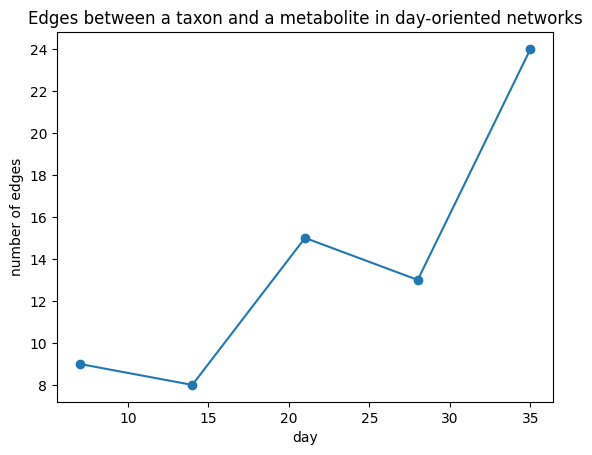

In [126]:
# What to plot
plt.plot(days, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in day-oriented networks")
# Show time
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [127]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in days_parsed_nets.items()
]

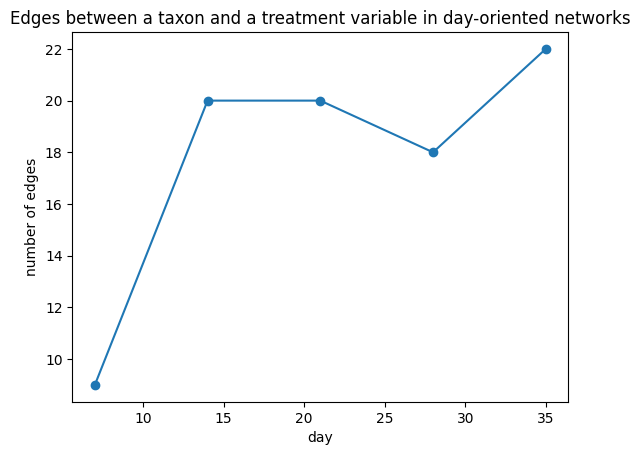

In [128]:
# What to plot
plt.plot(days, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a treatment variable in day-oriented networks")
# Show time
plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [129]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in days_parsed_nets.items()
]

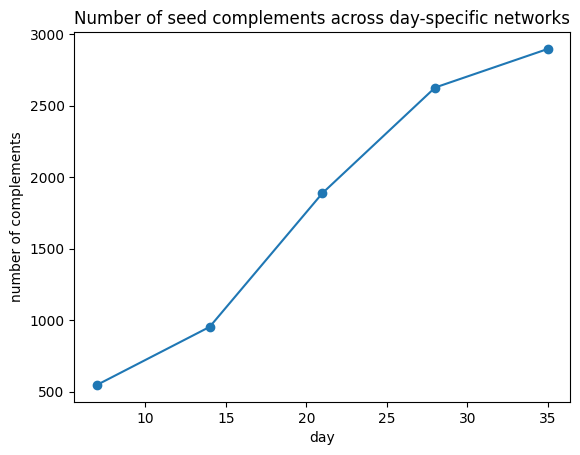

In [130]:
# What to plot
plt.plot(days, overall_number_of_seed_compl, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements across day-specific networks")
# Show time
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [131]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in days_parsed_nets.items()
]

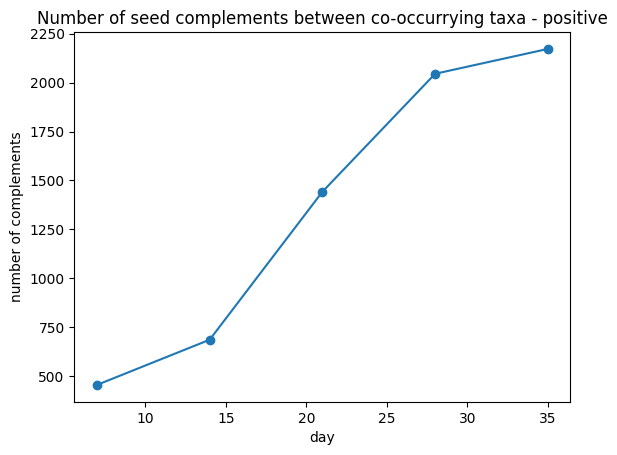

In [132]:
# What to plot
plt.plot(days, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")
# Show time
plt.show()

In [133]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(days_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(days_parsed_nets.values())
]

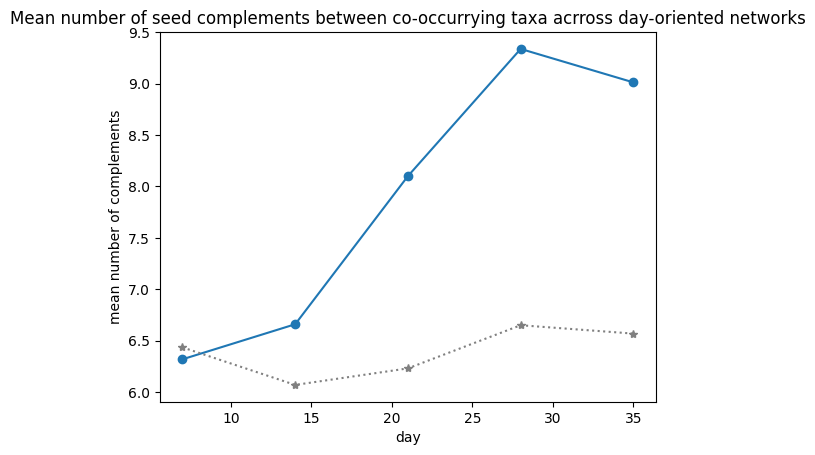

In [134]:
# What to plot
plt.plot(days, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(days, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")
# Labels and title
plt.xlabel("day")
plt.ylabel("mean number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross day-oriented networks")
# Show time
plt.show()

#### Unique compounds involved in potential cross-feedings

In [135]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in days_parsed_nets.items()
]

In [136]:
lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

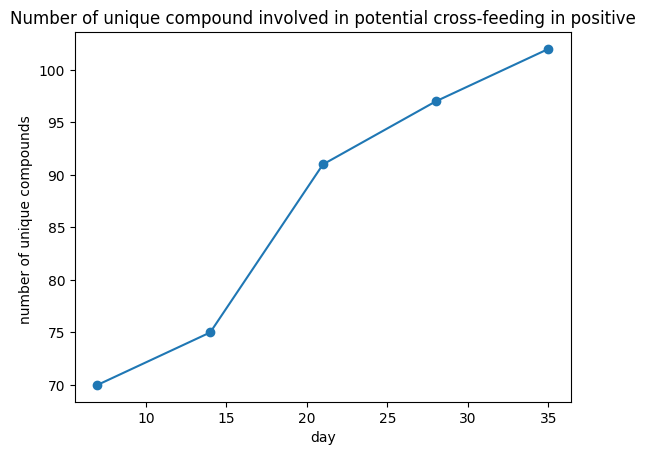

In [137]:
plt.plot(days, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [138]:
day_set = { "day_" + str(i): j for i,j in zip(days, unique_compounds_in_cf_of_positive_associated_taxa)}

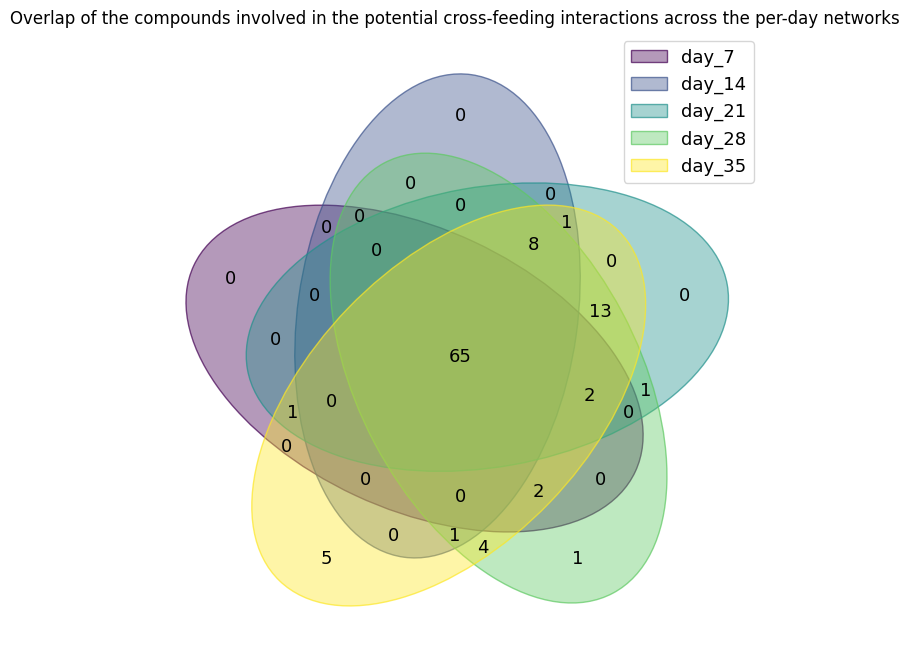

In [139]:
venn(day_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-day networks")

# Show the plot
plt.show()

In [15]:
dfs = {}

ratio_ggplots_wls, ratio_ggplots_ols = [], []

for _, day in enumerate(days_parsed_nets):                      # # NOTE (Haris Zafeiropoulos, 2025-04-02):  Enumerate will keep the same order as long as we do not edit the days_parased_nets dictionary

    day_net = days_parsed_nets[day]

    df = process_cooccurrence_and_regression(
        day_net, day, metabolites, env_set
    )

    dfs[day] = df


for day, df in dfs.items():

        ratio_ggplots_wls.append( plot_neighbors_per_seed_compl(df, day,  model="WLS") )  # or OLS
        ratio_ggplots_ols.append( plot_neighbors_per_seed_compl(df, day,  model="OLS") )

In [11]:
day_w_pearson = {}
day_spearman  = {}

for day, df in dfs.items():

    r2, p_v = weighted_pearson_with_pvalue(df, "neighbors_num", "compl_ratio", "compl_ratio")
    day_w_pearson[day] = {}
    day_w_pearson[day]["r^2"]    = r2
    day_w_pearson[day]["pvalue"] = p_v

    day_spearman[day] = spearman_corr(df, "neighbors_num", "compl_ratio")


In [12]:
pd.DataFrame.from_dict(day_spearman, orient="index", columns=["Spearman"])

,Spearman
day07,-0.015319
day14,-0.121013
day21,0.065173
day28,-0.070065
day35,-0.032861


In the `ratio_ggplots_ols`, we now have for each day net its corresponding plot:

In [26]:
COMPLEMENTS_NUMBER

'seed_compls_num'

In [ ]:
from plotnine import stat_smooth
from scipy.stats import linregress
import statsmodels.formula.api as smf

for day, case in zip(days, ratio_ggplots_wls):

    adf = case[1]
    adf["genome_size"] = adf["name"].map(genome_metadata.set_index("genome")["length"])
    adf["compls_per_neighbor"] = adf[COMPLEMENTS_NUMBER] / adf[NEIGHBORS_NUMBER]

    x = adf[NEIGHBORS_NUMBER]
    # y = adf[COMPLEMENTS_NUMBER]
    y = adf["compls_per_neighbor"]

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    model = smf.quantreg(f"{COMPLEMENTS_NUMBER} ~ {NEIGHBORS_NUMBER}", adf)
    res = model.fit(q=0.5)
    # Median regression coefficient for neighbors_num
    slope = res.params[NEIGHBORS_NUMBER]

    # Intercept
    intercept = res.params['Intercept']

    # p-value for the slope
    pval = res.pvalues[NEIGHBORS_NUMBER]

    # Pseudo R²
    pseudo_r2 = res.prsquared  # or res.rsquared if available# median regression
    print(res.summary())


    p = (
        ggplot(adf, aes(
            x     = NEIGHBORS_NUMBER,
            # y     = COMPLEMENTS_NUMBER,
            y = "compls_per_neighbor",
            color = 'order',              # assuming 'order' is a column
            size  = 'genome_size'         # map genome_size to point size
        ))
        + geom_point()
        + stat_smooth(method='lm', se=True, color='black')  # regression line
        + labs(
            color = 'Order',
            size  = 'Genome Size'
        )
        + theme_minimal()

        + labs(
        title = f"day {day} at the order level",
        x     = "Neighbors Number",
        # y     = "Seed Complements Number",
        y     = "Seed Complements per Neighbor",
        )
        + annotate(
            "text",
            x = adf[NEIGHBORS_NUMBER].max() * 0.8,
            y = adf["compls_per_neighbor"].max() * 0.9,
            label = f"Intercept = {intercept:.2f}\nSlope = {slope:.2f}\nPseudo R² = {pseudo_r2:.3f}\nP-value = {pval:.3g}",
            size = 10,
            color = "black",
        )

        # + annotate(
        #     "text",
        #     x     = adf[NEIGHBORS_NUMBER].max() * 0.8,
        #     y     = adf[RATIO].max() * 0.9,
        #     label = f"R² = {r_value:.3f}\nP-value = {p_value:.3g}",
        #     size  = 10,
        #     color = "black",
        # )
    )

    ggsave(
        p,
        filename = f"figs/seed_stats/day{day}_family_wls.png",
        dpi      = 300,
        width    = 8,
        height   = 6
    )


                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.4083
Model:                       QuantReg   Bandwidth:                       7.020
Method:                 Least Squares   Sparsity:                        13.93
Date:                Thu, 02 Oct 2025   No. Observations:                   54
Time:                        00:22:02   Df Residuals:                       52
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.0000      2.195     -0.456      0.651      -5.405       3.405
neighbors_num    13.0000      1.485      8.755      0.000      10.020      15.980


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/day7_family_wls.png


                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.4339
Model:                       QuantReg   Bandwidth:                       5.444
Method:                 Least Squares   Sparsity:                        12.76
Date:                Thu, 02 Oct 2025   No. Observations:                   77
Time:                        00:22:03   Df Residuals:                       75
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.2500      1.559      1.443      0.153      -0.856       5.356
neighbors_num     9.7500      0.892     10.926      0.000       7.972      11.528


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/day14_family_wls.png


                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.5153
Model:                       QuantReg   Bandwidth:                       6.067
Method:                 Least Squares   Sparsity:                        16.79
Date:                Thu, 02 Oct 2025   No. Observations:                  125
Time:                        00:22:03   Df Residuals:                      123
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.5000      1.693     -0.886      0.377      -4.851       1.851
neighbors_num    12.5000      0.818     15.290      0.000      10.882      14.118


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/day21_family_wls.png


                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.4563
Model:                       QuantReg   Bandwidth:                       6.766
Method:                 Least Squares   Sparsity:                        19.18
Date:                Thu, 02 Oct 2025   No. Observations:                  163
Time:                        00:22:04   Df Residuals:                      161
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3638      1.705      0.213      0.831      -3.003       3.730
neighbors_num    12.6362      0.787     16.059      0.000      11.082      14.190


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/day28_family_wls.png


                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.5036
Model:                       QuantReg   Bandwidth:                       5.843
Method:                 Least Squares   Sparsity:                        17.44
Date:                Thu, 02 Oct 2025   No. Observations:                  178
Time:                        00:22:05   Df Residuals:                      176
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.0000      1.407      2.133      0.034       0.224       5.776
neighbors_num    11.0000      0.646     17.018      0.000       9.724      12.276


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/day35_family_wls.png


To save all the per day plots with the seed complementarities number against the number of positive neighbors:

In [39]:
df = process_cooccurrence_and_regression(
        overall_mtg, "overall", metabolites, env_set
    )
df.head()

,id,neighbors_num,neighbors,seed_compls_num,name,species,family,order,condition,compl_ratio
12,12,4,"{46, 99, 6, 238}",60,D300452:bin_000016,s__Eisenbergiella sp904392525,f__Lachnospiraceae,o__Lachnospirales,overall,15.0
6,6,2,"{66, 12}",33,D300435:bin_000001,s__Anaerotignum merdipullorum,f__Anaerotignaceae,o__Lachnospirales,overall,16.5
24,24,4,"{25, 75, 236, 7}",56,D300493:bin_000002,s__Fimenecus stercoravium,f__Acutalibacteraceae,o__Oscillospirales,overall,14.0
7,7,2,"{24, 45}",34,D300442:bin_000001,s__Tyzzerella sp944383305,f__CAG-274,o__Lachnospirales,overall,17.0
8,8,2,"{11, 4}",24,D300442:bin_000015,s__Agathobaculum merdipullorum,f__Butyricicoccaceae,o__Oscillospirales,overall,12.0


In [ ]:
overall = plot_neighbors_per_seed_compl(df, "overall")
overall[1].head()

Use the genome metadata `df` we built in the beginning of the notebook, to get the genome size of each MAG.

In [177]:
for df in dfs.values():
    df["genome size"] = df["name"].map(genome_metadata.set_index("genome")["length"])
    df.rename(columns={"neighbors_num": "number of neighbors", "compl_ratio": "seed complements per neighbor"}, inplace=True)
df.head()

,id,number of neighbors,neighbors,seed_compls_num,name,species,family,order,condition,seed complements per neighbor,genome size
23,23,2,"{208, 23}",13,D300493:bin_000002,s__Fimenecus stercoravium,f__Acutalibacteraceae,o__Oscillospirales,day35,6.5,2043415
25,25,2,"{9, 2}",38,D300500:bin_000011,s__Gemmiger stercoravium,f__Ruminococcaceae,o__Oscillospirales,day35,19.0,1691313
9,9,2,"{25, 207}",36,D300443:bin_000003,s__Scatosoma sp900555925,f__Borkfalkiaceae,o__Christensenellales,day35,18.0,3351616
26,26,2,"{12, 182}",13,D300506:bin_000004,s__Agathobaculum stercoravium,f__Butyricicoccaceae,o__Oscillospirales,day35,6.5,2563225
12,12,1,{26},6,D300458:bin_000001,s__Coproplasma stercorigallinarum,f__Borkfalkiaceae,o__Christensenellales,day35,6.0,1947586


In [179]:
dfs.keys()

dict_keys(['day07', 'day14', 'day21', 'day28', 'day35'])

In [180]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df, 
    x        = 'number of neighbors',
    y        = 'seed complements per neighbor',
    z        = 'genome size',
    color    = 'order',
    symbol   = 'order',
    size_max = 10,
    opacity  = 0.8
)

In [169]:
# Save the plot as an HTML file
html_file = "plotly_3d_plot2.html"
fig.write_html(html_file)

# Open the HTML file in the default web browser
webbrowser.open(html_file)

True

/home/luna.kuleuven.be/u0156635/github_repos/contribute-to/AMAC005_chicken_salmonella/microbetag_analysis/plotly_3d_plot2.html:1
<html>
^

SyntaxError: Unexpected token '<'
    at wrapSafe (node:internal/modules/cjs/loader:1385:20)
    at Module._compile (node:internal/modules/cjs/loader:1435:41)
    at Module._extensions..js (node:internal/modules/cjs/loader:1564:10)
    at Module.load (node:internal/modules/cjs/loader:1295:32)
    at Module._load (node:internal/modules/cjs/loader:1111:12)
    at c._load (node:electron/js2c/node_init:2:16955)
    at Function.executeUserEntryPoint [as runMain] (node:internal/modules/run_main:188:12)
    at node:internal/main/run_main_module:28:49

Node.js v20.18.2


After I open the `.html` file on my browser, I turned it around a bit and I extracted its ***camera settings*** by moving to the *Inspect* and running the following command on the `Console`:


    JSON.stringify(document.querySelector("div.js-plotly-plot")._fullLayout.scene.camera)


In [172]:
camera_settings = {
    "up"        : {"x":0,"y":0,"z":1},
    "center"    : {"x":0,"y":0,"z":0},
    "eye"       : {"x":-1.0142173958395229,"y":1.6792529527047904,"z":0.9159544720174357},
    "projection": {"type":"perspective"}
}

In [173]:
fig.update_layout(
    scene_camera     = camera_settings,
    width            = 1200,               # Width of the figure in pixels
    height           = 1000,               # Height of the figure in pixels
    plot_bgcolor     = 'rgba(0, 0, 0, 0)', # Transparent background for the plot area
    paper_bgcolor    = 'rgba(0, 0, 0, 0)', # Transparent background for the surrounding area
    font             = dict(size=14),      # Increase font size for axes and other text elements
    title_font       = {"size": 40},
    yaxis_title_font = dict(size=20)   # Increase font size for y-axis label
)

fig.update_xaxes(title='New x label')

# Save the figure as an SVG file
pio.write_image(fig, "plot.svg")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [174]:
# cx_07
# days_parsed_nets["day07"].edge_types.keys()

taxa_pair_2_edge_id = {}
for edge_id in cx_07.get_edges():
    edge = cx_07.get_edge(edge_id)    
    pair = (edge["s"], edge["t"])
    if edge["v"]["interaction type"] != COMPL_INT_TYPE:
        taxa_pair_2_edge_id[pair] = edge_id


pos_weight_scores, neg_weight_scores = {}, {}

for edge_id in days_parsed_nets["day07"].edge_types["taxon_to_taxon"]["edges"]:
    edge = cx_07.get_edge(edge_id)

    if edge["v"]["interaction type"] in [COOCCURENCE, COEXCLUSION]:
        continue

    try:
        comp, coop, s, t = edge["v"][SEED_COMP], edge["v"][SEED_COOP], edge["s"], edge["t"]
    except Exception as e:
        print(f"Warning: {e} not found in edge {edge["v"].keys()}")
        continue

    eid = taxa_pair_2_edge_id.get((s, t), taxa_pair_2_edge_id.get((t, s)))

    fw_score = cx_07.get_edge(eid)["v"]["microbetag::weight"]
    target = pos_weight_scores if fw_score > 0 else neg_weight_scores
    
    target[edge_id] = {COOPERATION: coop, COMPETITION: comp}
    
    if fw_score > 0:
        target[edge_id][COOCCURENCE] = fw_score
    else:
        target[edge_id][COEXCLUSION] = fw_score


In [175]:
df = pd.DataFrame.from_dict(pos_weight_scores, orient="index")
df.head()

,cooperation,competition,co-occurrence
84,0.132231,0.601156,0.762256
85,0.070796,0.574586,0.762256
86,0.041916,0.729358,0.999990
87,0.069767,0.795000,0.999990
88,0.119403,0.657303,0.812418


In [84]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df[COOPERATION], df[COOCCURENCE])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df[COOPERATION], df[COOCCURENCE])
print("Spearman correlation:", spearman_corr)

Pearson correlation: 0.0618124762892509
Spearman correlation: 0.09620762843170465


In [85]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df[COMPETITION], df[COOCCURENCE])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df[COMPETITION], df[COOCCURENCE])
print("Spearman correlation:", spearman_corr)

Pearson correlation: -0.015812610785219526
Spearman correlation: 0.07879900218943665


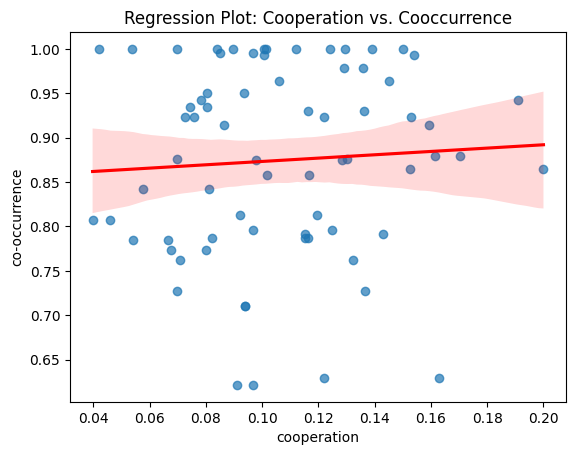

In [86]:
sns.regplot(
    x           = df[COOPERATION],
    y           = df[COOCCURENCE],
    scatter_kws = {"alpha": 0.7},
    line_kws    = {"color": "red"}
)
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [87]:
from scipy.stats import pearsonr, spearmanr
df = pd.DataFrame.from_dict(neg_weight_scores, orient="index")
df = df.astype(float) 
df.head()

pearson_corr, _ = pearsonr(df[COOPERATION], df[COEXCLUSION])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df[COOPERATION], df[COEXCLUSION])
print("Spearman correlation:", spearman_corr)

Pearson correlation: -0.20820165675950747
Spearman correlation: -0.20377134968227106


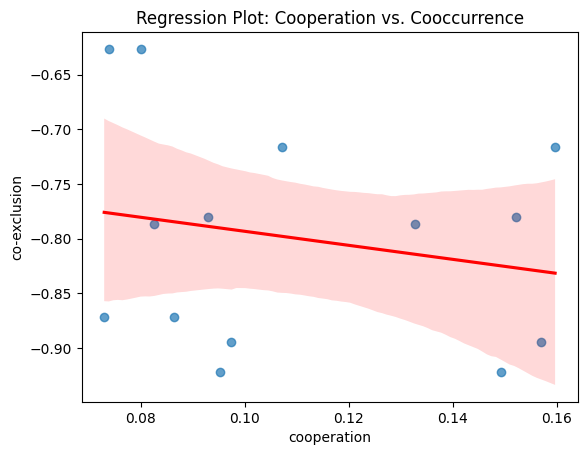

In [88]:
sns.regplot(
    x           = df[COOPERATION],
    y           = df[COEXCLUSION],
    scatter_kws = {"alpha": 0.7},
    line_kws    = {"color": "red"}
)
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

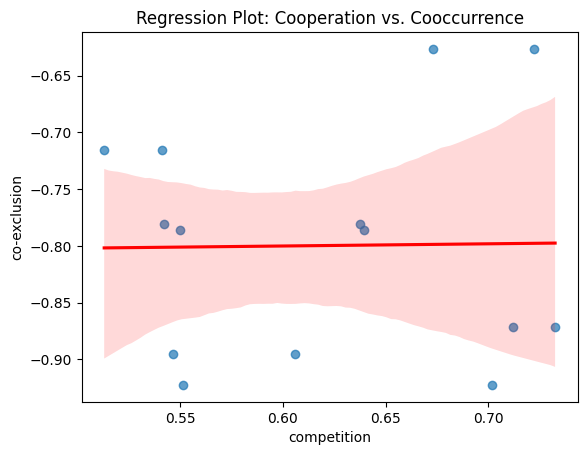

In [89]:
sns.regplot(
    x           = df[COMPETITION],
    y           = df[COEXCLUSION],
    scatter_kws = {"alpha": 0.7},
    line_kws    = {"color": "red"}
)
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [90]:
day_cx_objects = {
    "day07": cx_07,
    "day14": cx_14,
    "day21": cx_21,
    "day28": cx_28,
    "day35": cx_35
}

all_scores = {
    day: compute_weight_scores(cx_net, days_parsed_nets[day])
    for day, cx_net in day_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::c

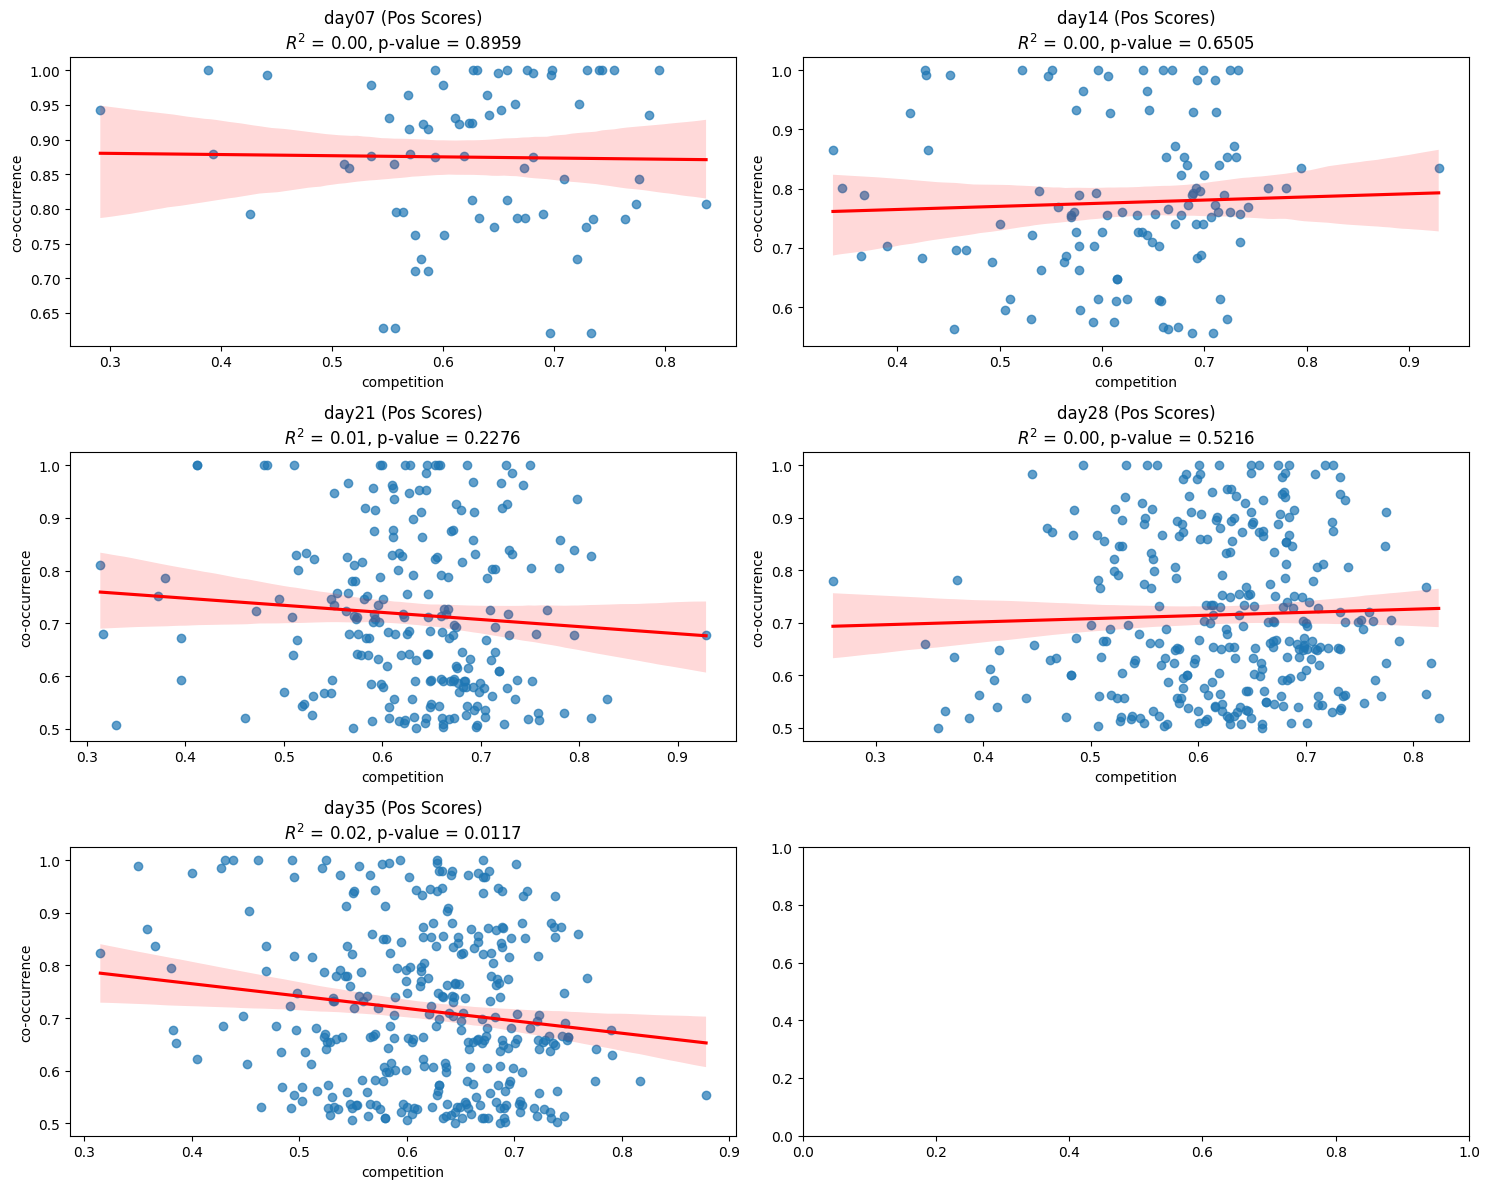

In [91]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not pos_df.empty:  # Plot positive weight scores
        plot_regression(axes[i], pos_df, COMPETITION, COOCCURENCE, f"{day} (Pos Scores)")
        # plot_regression(axes[i], pos_df, COOPERATION, COOCCURENCE, f"{day} (Pos Scores)")
        # plot_dual_regression(axes[i], pos_df, COOCCURENCE, COOPERATION, COMPETITION, f"{day} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

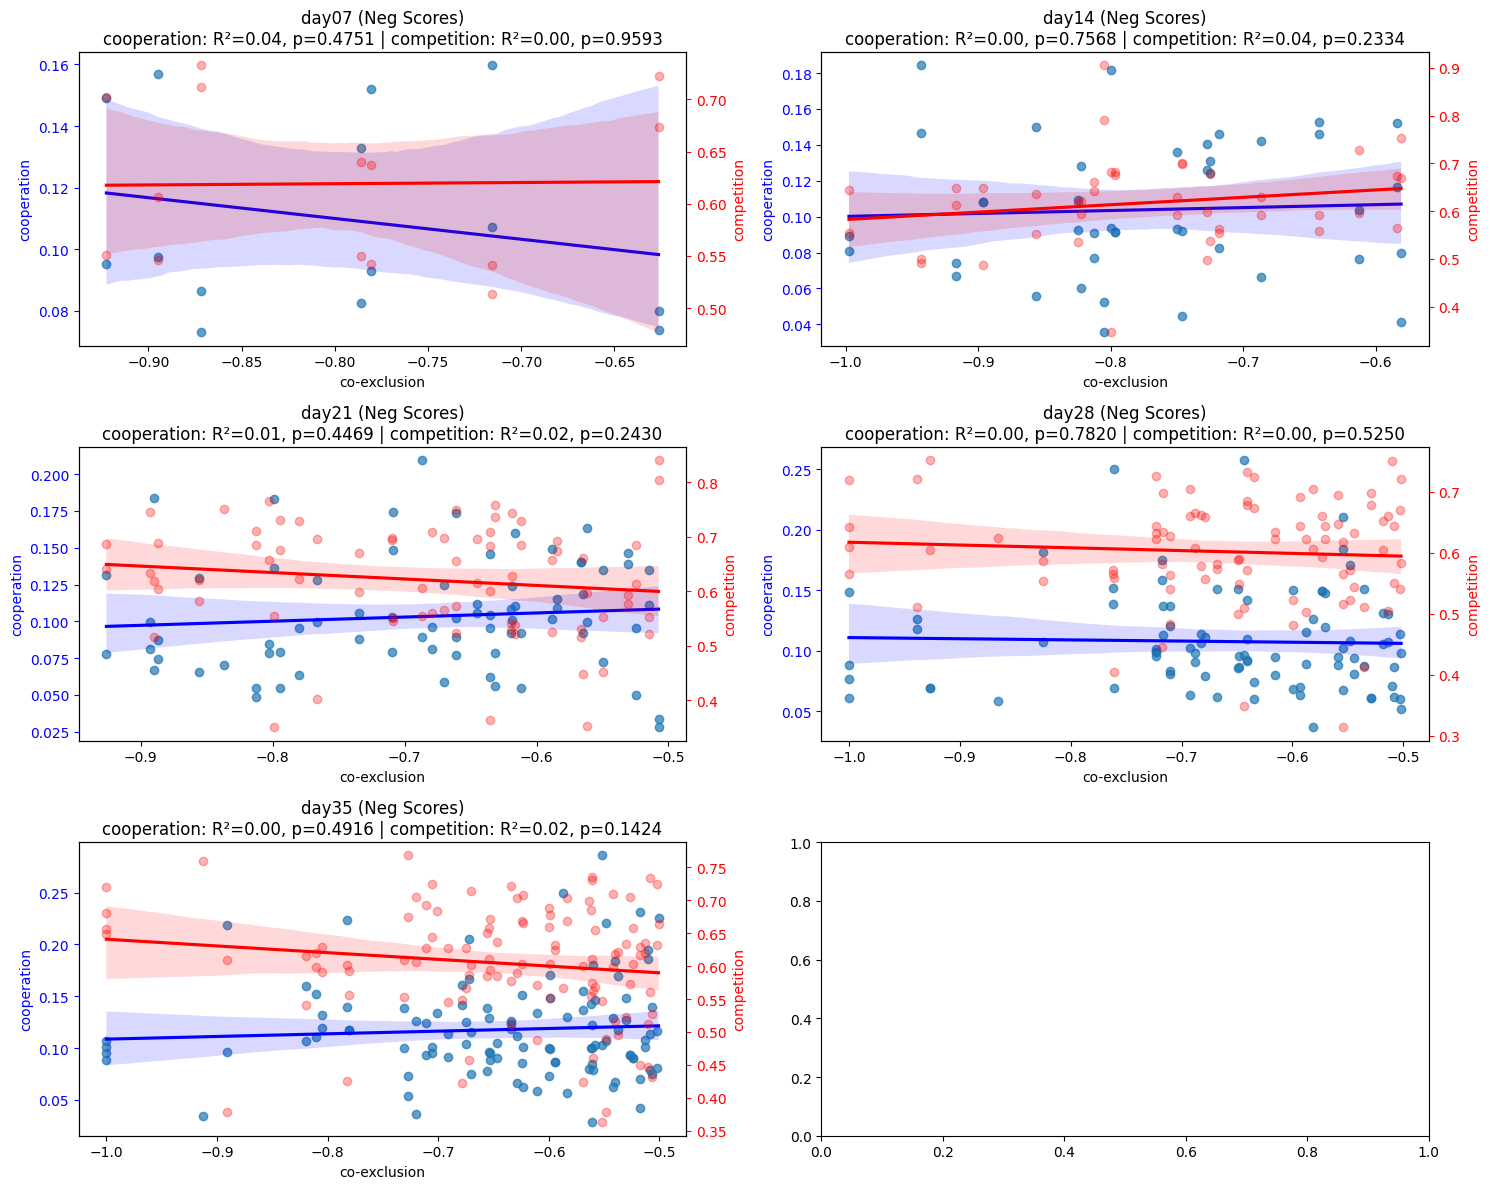

In [92]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
 
    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            # plot_regression(axes[i + 1], neg_df, COMPETITION, COEXCLUSION, f"{day} (Neg Scores)")
            # plot_regression(axes[i + 1], neg_df, COOPERATION, COEXCLUSION, f"{day} (Neg Scores)")
            plot_dual_regression(axes[i], neg_df, COEXCLUSION, COOPERATION, COMPETITION, f"{day} (Neg Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Per treatment

#### Prep

In [31]:
cx_tg1_filepath = os.path.join(cx_dir, "TG_1.cx2") ; cx_tg_1 = load_cx2(cx_tg1_filepath)
cx_tg2_filepath = os.path.join(cx_dir, "TG_2.cx2") ; cx_tg_2 = load_cx2(cx_tg2_filepath)
cx_tg3_filepath = os.path.join(cx_dir, "TG_3.cx2") ; cx_tg_3 = load_cx2(cx_tg3_filepath)
cx_tg4_filepath = os.path.join(cx_dir, "TG_4.cx2") ; cx_tg_4 = load_cx2(cx_tg4_filepath)
cx_tg5_filepath = os.path.join(cx_dir, "TG_5.cx2") ; cx_tg_5 = load_cx2(cx_tg5_filepath)

In [32]:
treatment_parsed_nets = {
    "TG_1" : MggParser(cx_tg_1, env_set, metabolites_set),
    "TG_2" : MggParser(cx_tg_2, env_set, metabolites_set),
    "TG_3" : MggParser(cx_tg_3, env_set, metabolites_set),
    "TG_4" : MggParser(cx_tg_4, env_set, metabolites_set),
    "TG_5" : MggParser(cx_tg_5, env_set, metabolites_set)
}

In [33]:
treatment_cx_objects = {
    "TG_1": cx_tg_1,
    "TG_2": cx_tg_2,
    "TG_3": cx_tg_3,
    "TG_4": cx_tg_4,
    "TG_5": cx_tg_5
}

In [34]:
all_scores_treatments = {
    treatment: compute_weight_scores(cx_net, treatment_parsed_nets[treatment])
    for treatment, cx_net in treatment_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::competition'
This would lead to ERROR: 'seed::c

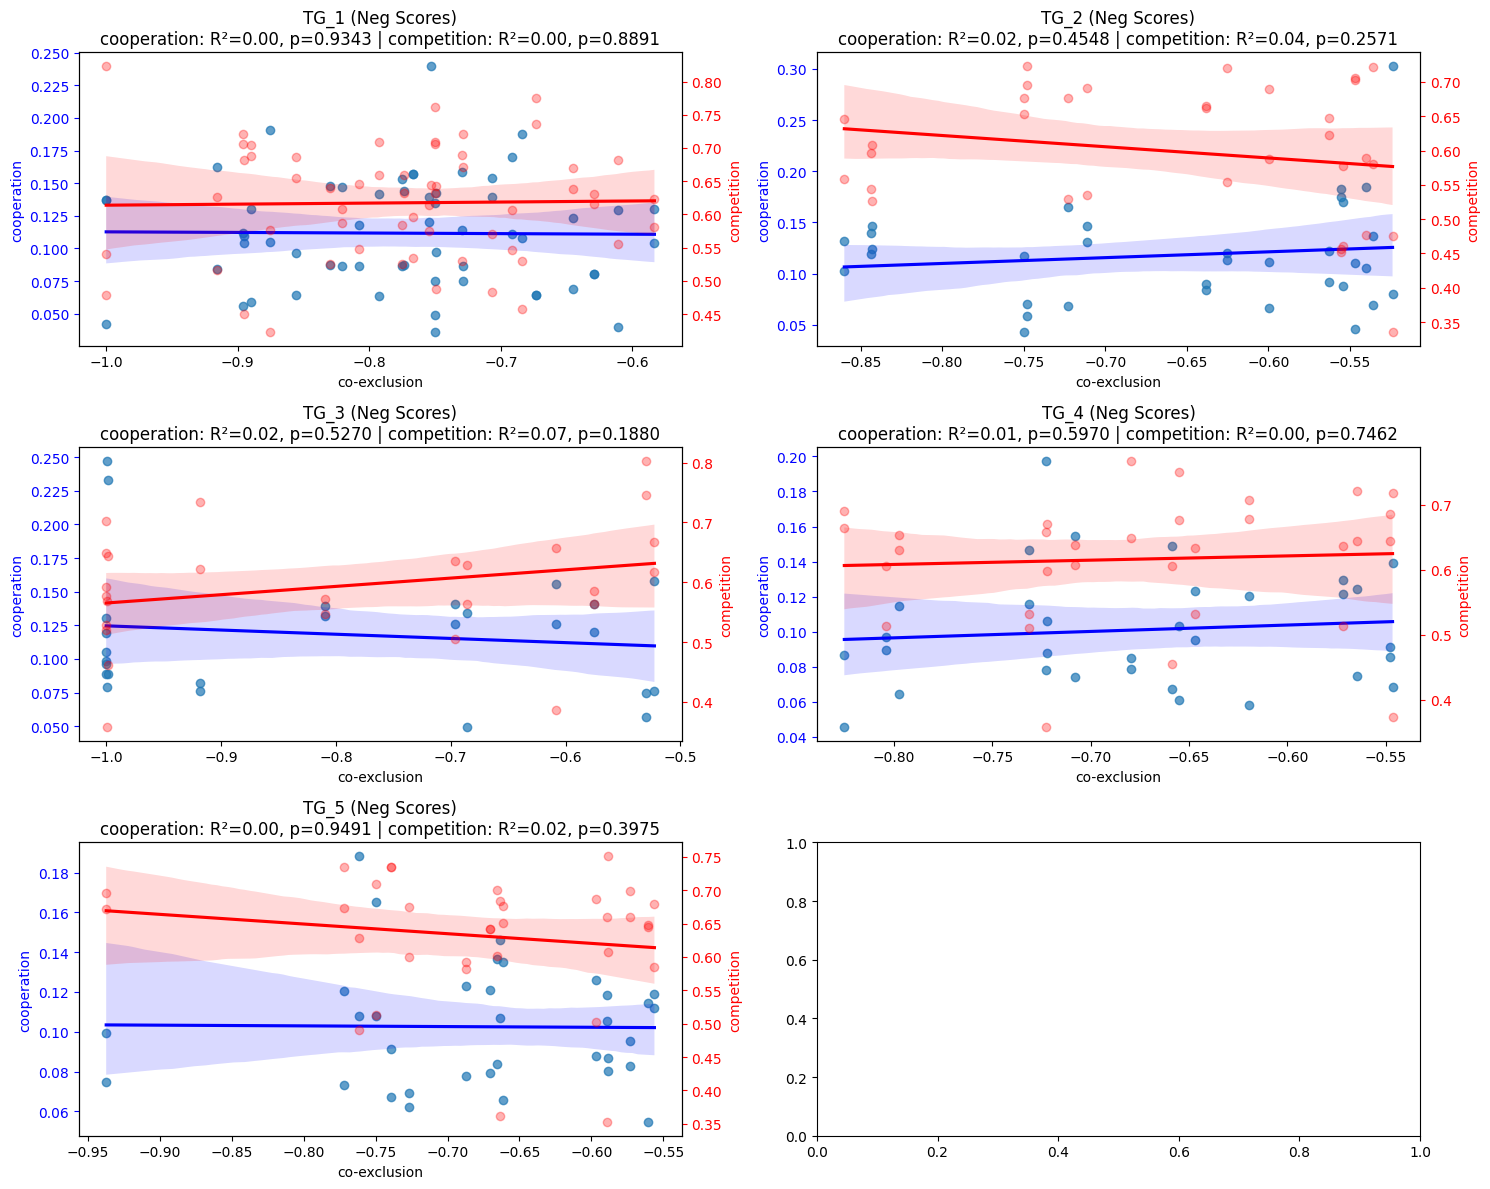

In [ ]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  

axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (treatment, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df     = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df     = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            plot_dual_regression(axes[i], neg_df, COEXCLUSION, COOPERATION, COMPETITION, f"{treatment} (Neg Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

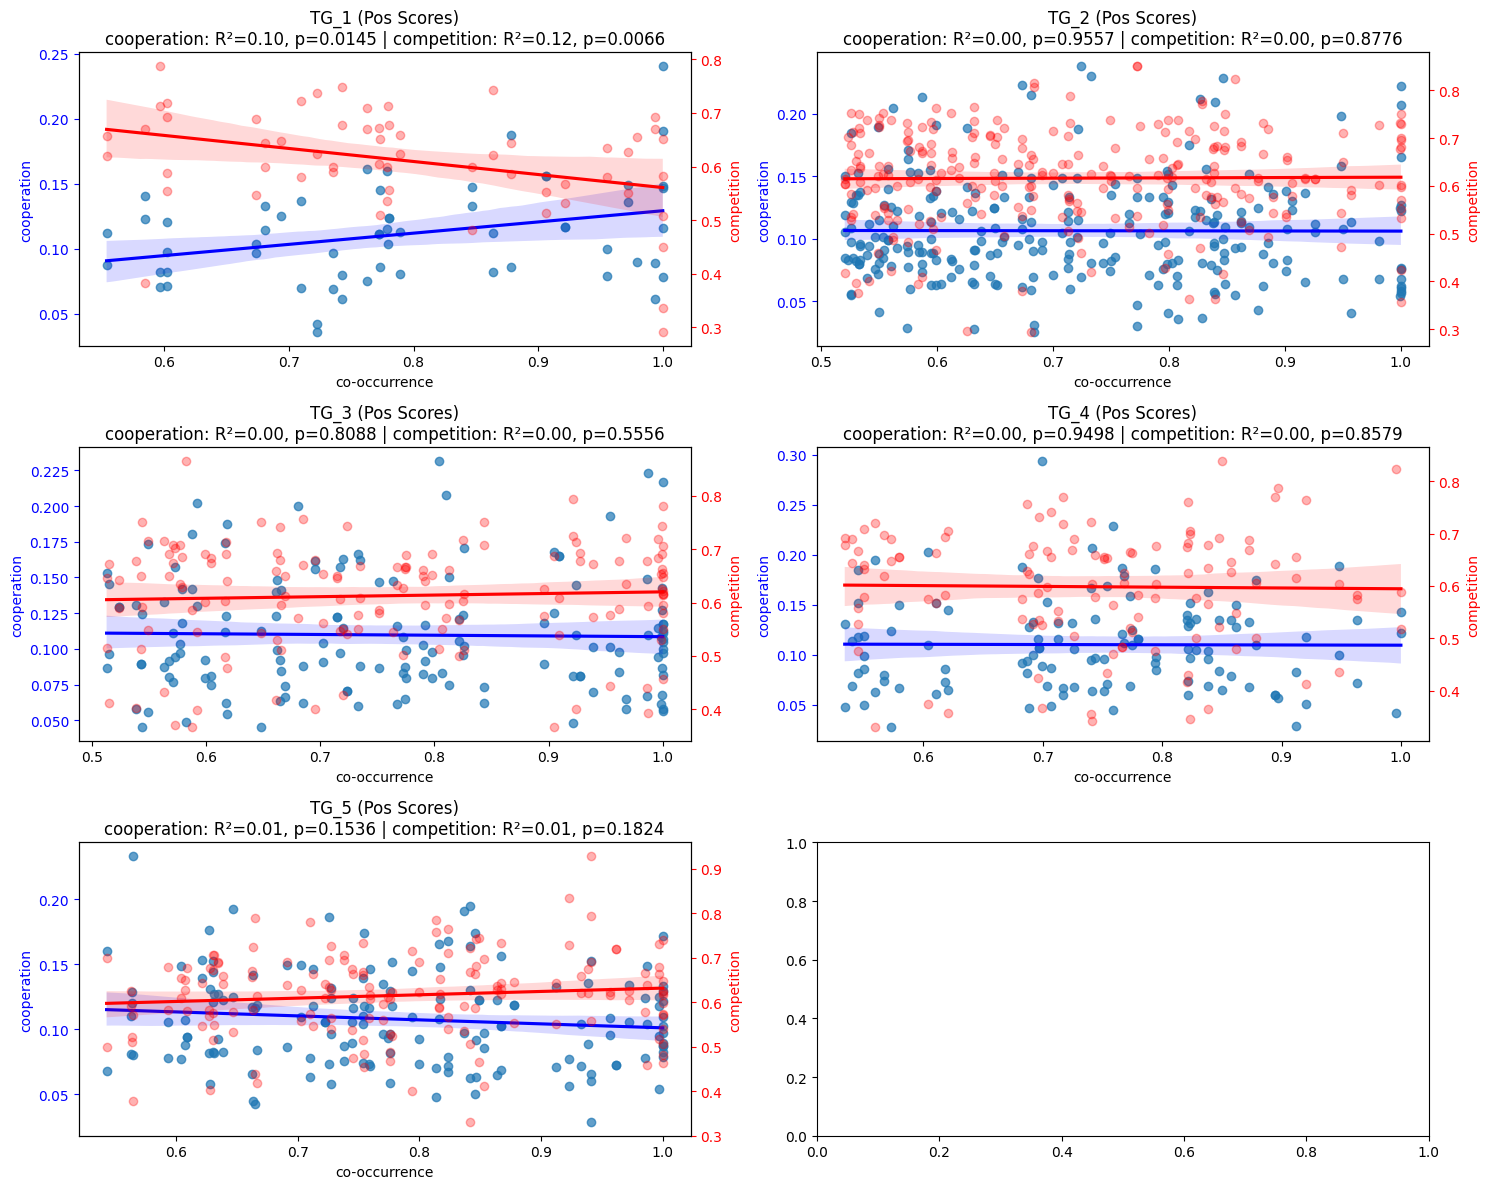

In [50]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (treatment, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break
    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    if not pos_df.empty:  # Plot positive weight scores
        # plot_regression(axes[i], pos_df, COOPERATION, COOCCURENCE, f"{day} (Pos Scores)")
        plot_dual_regression(axes[i], pos_df, COOCCURENCE, COOPERATION, COMPETITION, f"{treatment} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
pos_df

In [35]:
tg_microbetag_nets = [cx_tg_1, cx_tg_2, cx_tg_3, cx_tg_4, cx_tg_5]
treatments = ["TG1", "TG2", "TG3", "TG4", "TG5"]
treatments_descr = [
    "TG1:Salmonella, synbiont both water and feed",
    "TG2:Salmonella, synbiont in water",
    "TG3:Salmonella, synbiont in feed",
    "TG4:Salmonella, no symbiont",
    "TG5:No Salmonella, no symbiont"
]

In [36]:
parsed_tg_edges = []
for tg_mgg_net in tg_microbetag_nets:
    num_compl, types, pos_pairs, compounds = parse_microbetag_edges(tg_mgg_net, env_set=env_set, metabolites_set=metabolites_set)
    parsed_tg_edges.append([num_compl, types, pos_pairs, compounds])

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [101]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in treatment_parsed_nets.items()
]

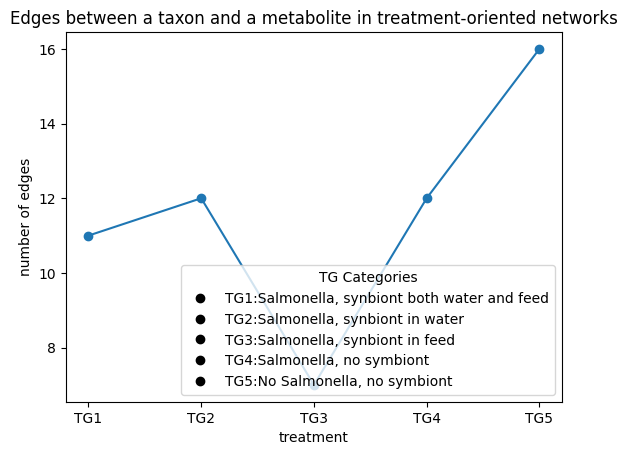

In [102]:
plt.plot(treatments, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in treatment-oriented networks")
# Create proxy artists for legend
legend_handles = [mlines.Line2D([], [], color='black', marker='o', linestyle='None', label=t) for t in treatments_descr]
# Add legend box
plt.legend(handles=legend_handles, title="TG Categories", loc="lower right", frameon=True)
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [103]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in treatment_parsed_nets.items()
]

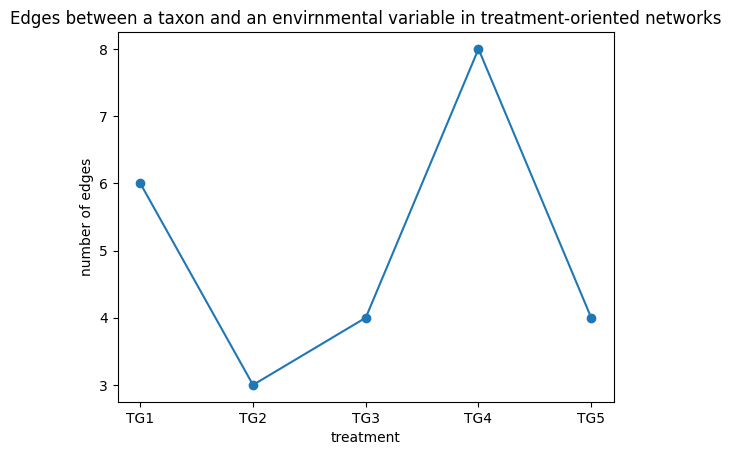

In [104]:
plt.plot(treatments, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and an envirnmental variable in treatment-oriented networks")

plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [105]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in treatment_parsed_nets.items()
]

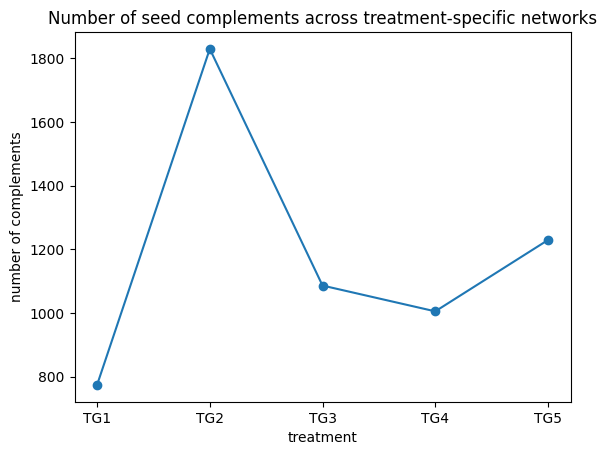

In [106]:
plt.plot(treatments, overall_number_of_seed_compl, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements across treatment-specific networks")

# Show the plot
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [107]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in treatment_parsed_nets.items()
]

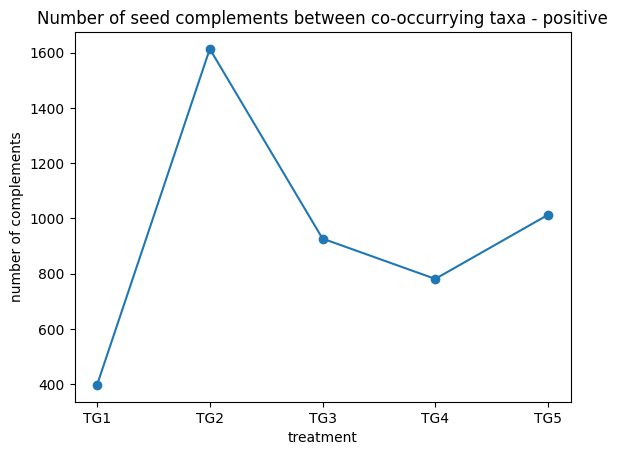

In [108]:
plt.plot(treatments, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")

# Show the plot
plt.show()

In [109]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(treatment_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(treatment_parsed_nets.values())
]

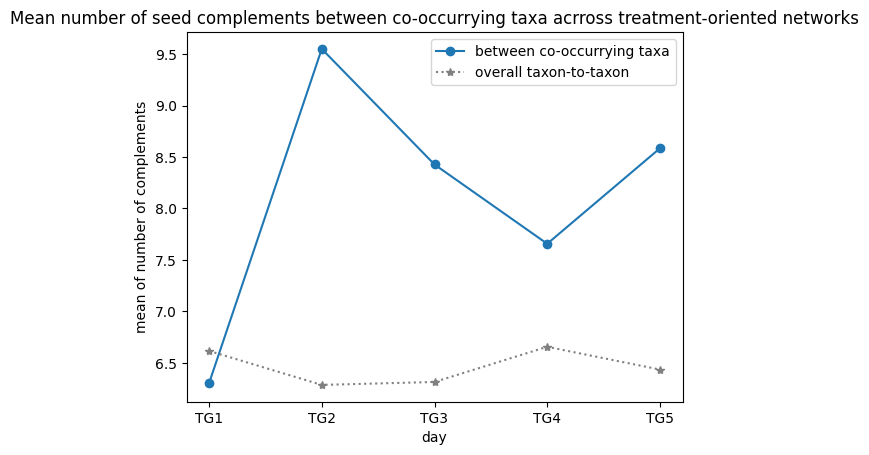

In [110]:
plt.plot(treatments, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(treatments, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")

# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross treatment-oriented networks")

plt.legend()

# Show the plot
plt.show()

#### Unique compounds involved in potential cross-feedings of co-occurrying taxa

In [111]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in treatment_parsed_nets.items()
]

lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

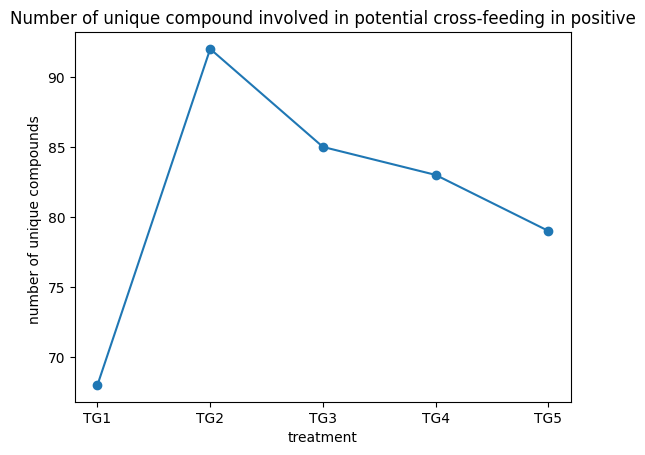

In [112]:
plt.plot(treatments, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [113]:
treatment_set = { i: j for i,j in zip(treatments, unique_compounds_in_cf_of_positive_associated_taxa)}

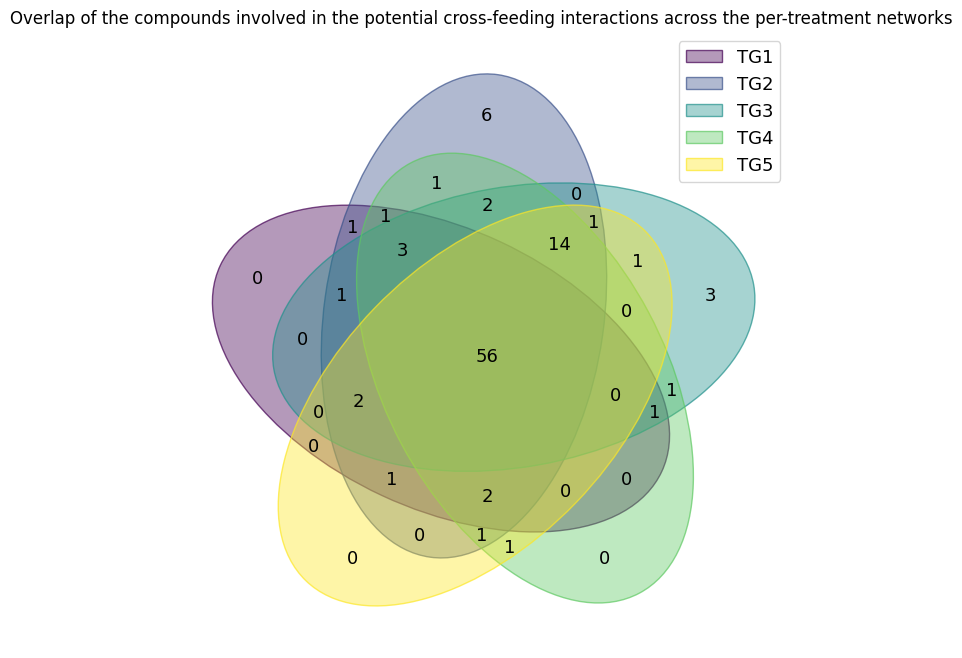

In [114]:
venn(treatment_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-treatment networks")

# Show the plot
plt.show()

In [38]:
dfs = {}

ratio_ggplots_wls, ratio_ggplots_ols = [], []

for _, treatment in enumerate(treatment_parsed_nets):

    tr_net = treatment_parsed_nets[treatment]

    df = process_cooccurrence_and_regression(
        tr_net, treatment, metabolites, env_set
    )

    dfs[treatment] = df


for treatment, df in dfs.items():

        ratio_ggplots_wls.append( plot_neighbors_per_seed_compl(df, treatment,  model="WLS") )  # or OLS
        ratio_ggplots_ols.append( plot_neighbors_per_seed_compl(df, treatment,  model="OLS") )

In [39]:

for treatment, case in zip(treatments, ratio_ggplots_wls):

    adf = case[1]
    adf["genome_size"] = adf["name"].map(genome_metadata.set_index("genome")["length"])
    adf["compls_per_neighbor"] = adf[COMPLEMENTS_NUMBER] / adf[NEIGHBORS_NUMBER]

    x = adf[NEIGHBORS_NUMBER]
    # y = adf[COMPLEMENTS_NUMBER]
    y = adf["compls_per_neighbor"]

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    model = smf.quantreg(f"{COMPLEMENTS_NUMBER} ~ {NEIGHBORS_NUMBER}", adf)
    res = model.fit(q=0.5)
    # Median regression coefficient for neighbors_num
    slope = res.params[NEIGHBORS_NUMBER]

    # Intercept
    intercept = res.params['Intercept']

    # p-value for the slope
    pval = res.pvalues[NEIGHBORS_NUMBER]

    # Pseudo R²
    pseudo_r2 = res.prsquared  # or res.rsquared if available# median regression
    print(res.summary())


    p = (
        ggplot(adf, aes(
            x     = NEIGHBORS_NUMBER,
            # y     = COMPLEMENTS_NUMBER,
            y = "compls_per_neighbor",
            color = 'order',              # assuming 'order' is a column
            size  = 'genome_size'         # map genome_size to point size
        ))
        + geom_point()
        + stat_smooth(method='lm', se=True, color='black')  # regression line
        + labs(
            color = 'Order',
            size  = 'Genome Size'
        )
        + theme_minimal()

        + labs(
        title = f"day {day} at the order level",
        x     = "Neighbors Number",
        # y     = "Seed Complements Number",
        y     = "Seed Complements per Neighbor",
        )
        + annotate(
            "text",
            x = adf[NEIGHBORS_NUMBER].max() * 0.8,
            y = adf["compls_per_neighbor"].max() * 0.9,
            label = f"Intercept = {intercept:.2f}\nSlope = {slope:.2f}\nPseudo R² = {pseudo_r2:.3f}\nP-value = {pval:.3g}",
            size = 10,
            color = "black",
        )

        # + annotate(
        #     "text",
        #     x     = adf[NEIGHBORS_NUMBER].max() * 0.8,
        #     y     = adf[RATIO].max() * 0.9,
        #     label = f"R² = {r_value:.3f}\nP-value = {p_value:.3g}",
        #     size  = 10,
        #     color = "black",
        # )
    )
    
    
    ggsave(
        p,
        filename = f"figs/seed_stats/{treatment}_family_wls.png",
        dpi      = 300,
        width    = 8,
        height   = 6
    )

                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.3489
Model:                       QuantReg   Bandwidth:                       5.319
Method:                 Least Squares   Sparsity:                        12.76
Date:                Thu, 02 Oct 2025   No. Observations:                   51
Time:                        00:29:09   Df Residuals:                       49
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.0000      2.722     -1.102      0.276      -8.471       2.471
neighbors_num    15.0000      2.049      7.320      0.000      10.882      19.118


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/TG1_family_wls.png


                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.4709
Model:                       QuantReg   Bandwidth:                       6.806
Method:                 Least Squares   Sparsity:                        18.29
Date:                Thu, 02 Oct 2025   No. Observations:                  126
Time:                        00:29:09   Df Residuals:                      124
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.0000      1.923      1.040      0.300      -1.805       5.805
neighbors_num    11.0000      0.844     13.035      0.000       9.330      12.670


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/TG2_family_wls.png


                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.5983
Model:                       QuantReg   Bandwidth:                       6.232
Method:                 Least Squares   Sparsity:                        14.43
Date:                Thu, 02 Oct 2025   No. Observations:                   81
Time:                        00:29:10   Df Residuals:                       79
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4989      1.706     -0.292      0.771      -3.894       2.896
neighbors_num    12.4996      0.797     15.683      0.000      10.913      14.086


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/TG3_family_wls.png


                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.5140
Model:                       QuantReg   Bandwidth:                       6.481
Method:                 Least Squares   Sparsity:                        15.46
Date:                Thu, 02 Oct 2025   No. Observations:                   73
Time:                        00:29:11   Df Residuals:                       71
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0000      1.929      0.518      0.606      -2.846       4.846
neighbors_num    12.0000      1.003     11.964      0.000      10.000      14.000


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/TG4_family_wls.png


                         QuantReg Regression Results                          
Dep. Variable:        seed_compls_num   Pseudo R-squared:               0.5096
Model:                       QuantReg   Bandwidth:                       7.398
Method:                 Least Squares   Sparsity:                        17.37
Date:                Thu, 02 Oct 2025   No. Observations:                   86
Time:                        00:29:12   Df Residuals:                       84
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.3333      1.961      1.699      0.093      -0.567       7.234
neighbors_num    11.6667      0.938     12.437      0.000       9.801      13.532


/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/miniconda3/envs/fig3/lib/python3.13/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/seed_stats/TG5_family_wls.png


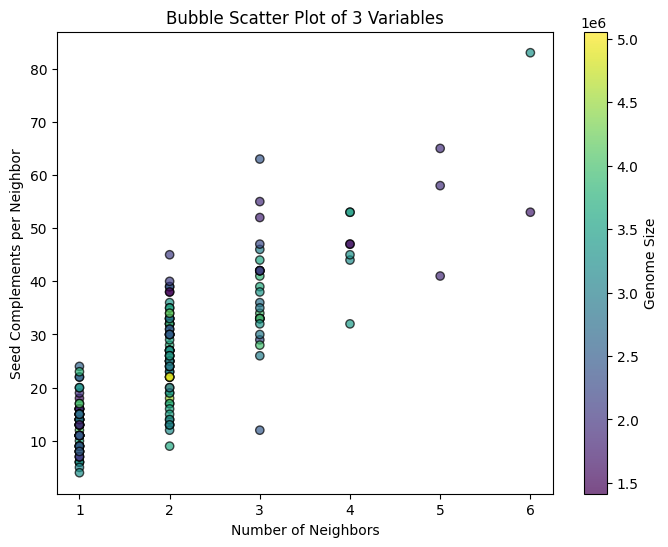

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
# np.random.seed(0)
# df = pd.DataFrame({
#     'neighbors': np.random.randint(1, 10, 100),  # discrete
#     'seed_complements': np.random.rand(100) * 5,  # float
#     'genome_size': np.random.rand(100) * 4 + 1   # float
# })

# --------- 1. Bubble scatter plot ---------
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df['num_neighbors'], 
    df['seed_compls_num'],
    # s=df['genome_size'],           # scale marker size
    c=df['genome_size'],              # color by genome size
    cmap='viridis', alpha=0.7, edgecolor='k'
)
plt.colorbar(scatter, label='Genome Size')
plt.xlabel('Number of Neighbors')
plt.ylabel('Seed Complements per Neighbor')
plt.title('Bubble Scatter Plot of 3 Variables')
plt.show()



In [186]:
df.columns = [
    'id', 'num_neighbors', 'neighbors', 'seed_compls_num', 'name',
    'species', 'family', 'order', 'condition',
    'seed_complements_per_neighbor', 'genome_size'
]

In [189]:
df.shape

(178, 11)